In [1]:
import pandas as pd
import numpy as np
from Classifications import InspectionClassifications

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split,  GridSearchCV
import keras
from keras import layers
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib

In [2]:
date_ = '03.11.2025'
citation_start_date = pd.to_datetime('2014-01-01')
citation_end_date = pd.to_datetime('2024-01-01')

In [3]:
IC = InspectionClassifications(date_)

q:\00- PROJECTS\FDA\Inspections\Classifications.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fei_ros_df = pd.read_sql_query('''select [t].[FEINumber], [t].NDC,


In [4]:
input_df, input_full_df, data_df, act_df, ss_list = IC.preprocess(citation_start_date,citation_end_date)

In [5]:
id_test = list(set(data_df[data_df.InspectionEndDate > citation_end_date]['InspectionID'].unique()) - set([1238442]))
start_date = pd.to_datetime('2017-01-01')
id_train =  list(data_df[(data_df.InspectionEndDate <= citation_end_date) & (data_df.InspectionEndDate >= start_date)]['InspectionID'].unique())

id_train = list(set(id_train).intersection(set(input_df.index)))
id_test = list(set(id_test).intersection(set(input_df.index)))

input_trim_df = input_df.loc[id_train+id_test]

In [6]:
X_train, X_test, y_train, y_test = input_trim_df.drop('Classification',axis=1).loc[id_train],input_trim_df.drop('Classification',axis=1).loc[id_test], input_trim_df[['Classification']].loc[id_train], input_trim_df[['Classification']].loc[id_test]

In [7]:
def make_results(y, y_pred):
    conf_mat = confusion_matrix(y,y_pred)
    fig, ax = plt.subplots(figsize=(15, 5))
    disp = ConfusionMatrixDisplay(conf_mat, display_labels = ['VAI','OAI'])
    disp.plot(cmap=plt.cm.BuPu,ax=ax)
    prec, rec, acc, f1 = precision_score(y,y_pred), recall_score(y,y_pred), accuracy_score(y,y_pred), f1_score(y,y_pred)
    print('Accuracy:',acc)
    print('F1:',f1)
    print('Recall:',rec)
    print('Precision:',prec)
    return acc, f1, rec, prec

# Downsampled

In [8]:
num_oais = len(y_train[y_train.Classification == 1])
non_oais_df = X_train.loc[y_train[y_train.Classification == 0].index]
non_oais_list = list(non_oais_df.sample(n =int(np.ceil(1* num_oais)), random_state = 1).index)
oais_list = list(y_train[y_train.Classification == 1].index)
X_ds_train, y_ds_train = X_train.loc[oais_list+non_oais_list], y_train.loc[oais_list+non_oais_list]

## Linear Regression

### Tuning

#### Standard

In [9]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_ds_train,y_ds_train)
y_train_pred = logreg.predict(X_ds_train)
y_test_pred = logreg.predict(X_test)

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7822719449225474
F1: 0.7824591573516767
Recall: 0.7831325301204819
Precision: 0.781786941580756


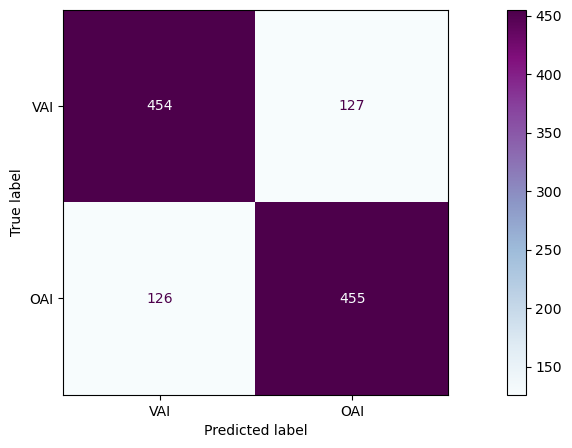

In [10]:
acc, f1, rec, prec = make_results(y_ds_train,y_train_pred)

#### ElasticNet

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7822719449225474
F1: 0.7824591573516767
Recall: 0.7831325301204819
Precision: 0.781786941580756
Accuracy: 0.7955801104972375
F1: 0.6574074074074074
Recall: 0.8987341772151899
Precision: 0.5182481751824818


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7814113597246127
F1: 0.7814113597246127
Recall: 0.7814113597246127
Precision: 0.7814113597246127
Accuracy: 0.7955801104972375
F1: 0.6574074074074074
Recall: 0.8987341772151899
Precision: 0.5182481751824818


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7779690189328744
F1: 0.7775862068965518
Recall: 0.7762478485370051
Precision: 0.7789291882556131
Accuracy: 0.7983425414364641
F1: 0.6604651162790698
Recall: 0.8987341772151899
Precision: 0.5220588235294118


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7788296041308089
F1: 0.7782571182053495
Recall: 0.7762478485370051
Precision: 0.7802768166089965
Accuracy: 0.7983425414364641
F1: 0.6604651162790698
Recall: 0.8987341772151899
Precision: 0.5220588235294118


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7796901893287436
F1: 0.7796901893287436
Recall: 0.7796901893287436
Precision: 0.7796901893287436
Accuracy: 0.7983425414364641
F1: 0.6604651162790698
Recall: 0.8987341772151899
Precision: 0.5220588235294118


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7796901893287436
F1: 0.7793103448275862
Recall: 0.7779690189328744
Precision: 0.7806563039723662
Accuracy: 0.7955801104972375
F1: 0.6574074074074074
Recall: 0.8987341772151899
Precision: 0.5182481751824818


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7788296041308089
F1: 0.7782571182053495
Recall: 0.7762478485370051
Precision: 0.7802768166089965
Accuracy: 0.7983425414364641
F1: 0.6604651162790698
Recall: 0.8987341772151899
Precision: 0.5220588235294118


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7796901893287436
F1: 0.7793103448275862
Recall: 0.7779690189328744
Precision: 0.7806563039723662
Accuracy: 0.7955801104972375
F1: 0.6574074074074074
Recall: 0.8987341772151899
Precision: 0.5182481751824818


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7814113597246127
F1: 0.7814113597246127
Recall: 0.7814113597246127
Precision: 0.7814113597246127
Accuracy: 0.787292817679558
F1: 0.6484018264840182
Recall: 0.8987341772151899
Precision: 0.5071428571428571


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7805507745266781
F1: 0.7803617571059431
Recall: 0.7796901893287436
Precision: 0.7810344827586206
Accuracy: 0.787292817679558
F1: 0.6484018264840182
Recall: 0.8987341772151899
Precision: 0.5071428571428571


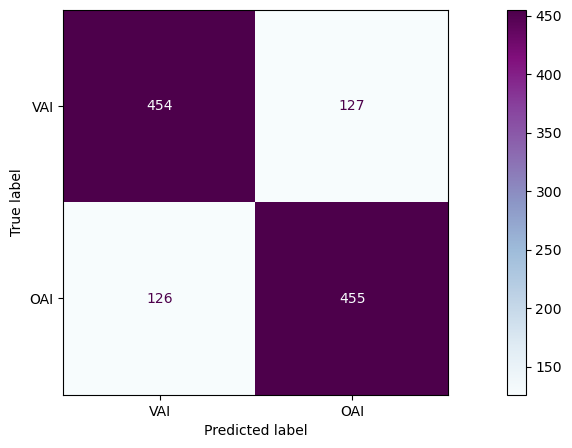

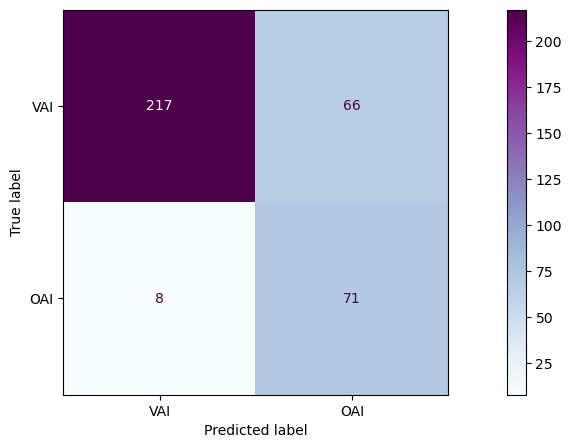

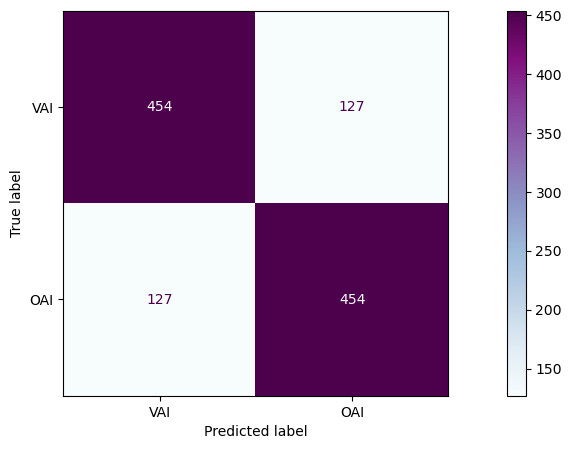

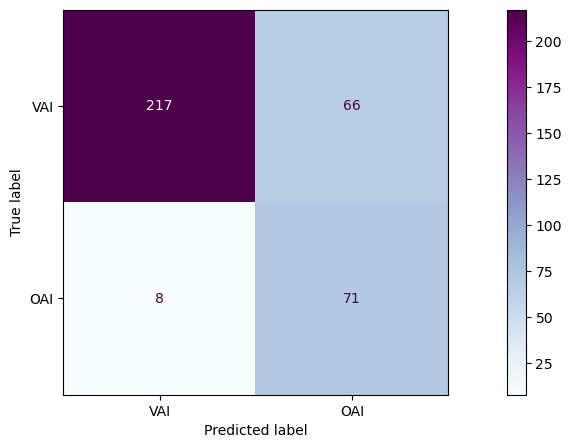

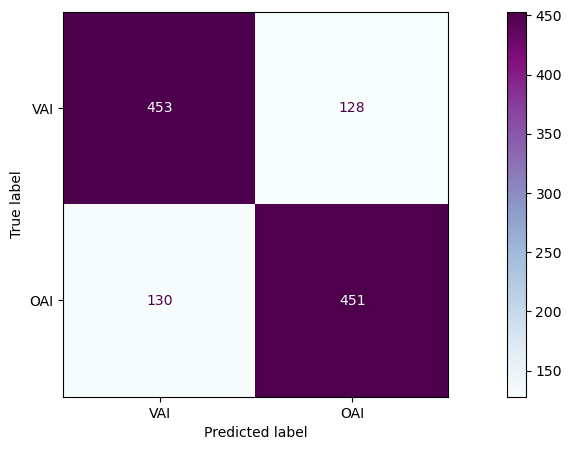

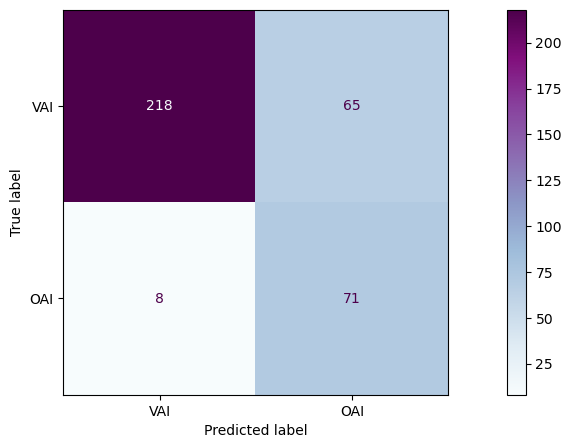

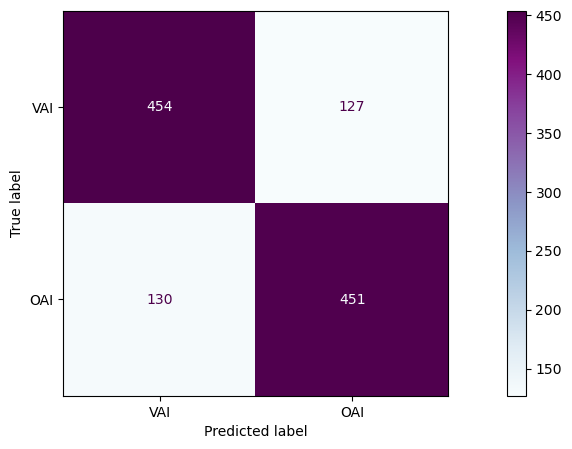

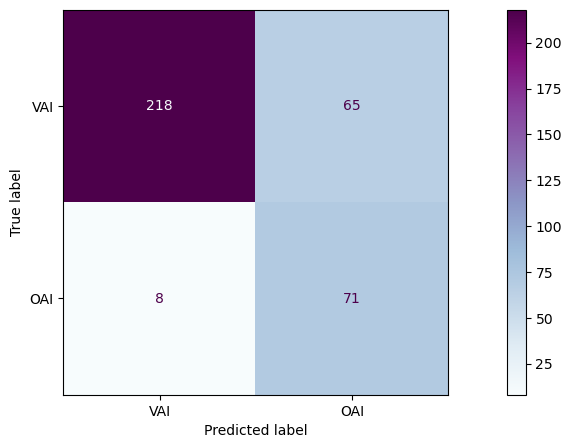

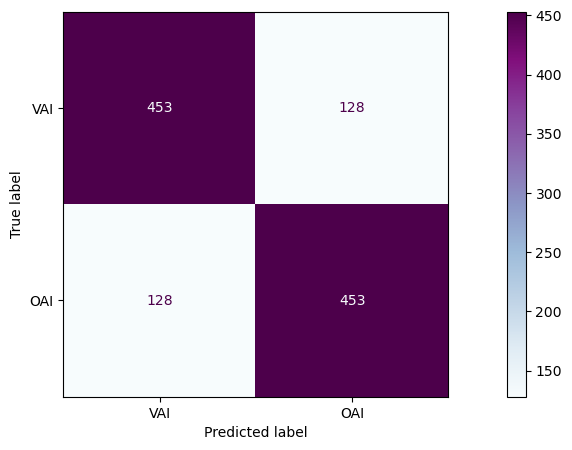

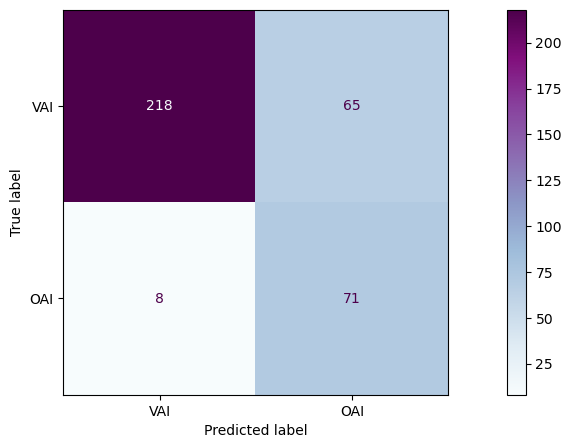

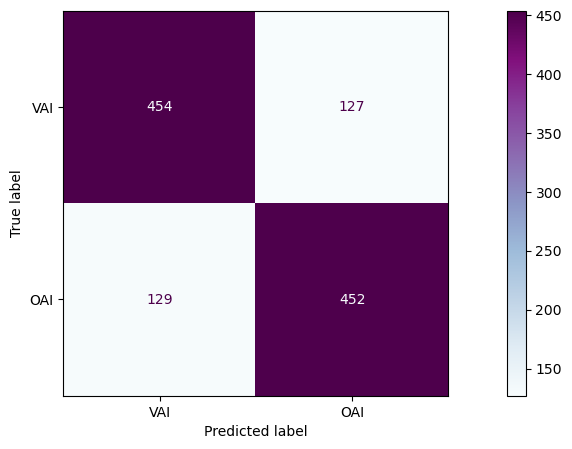

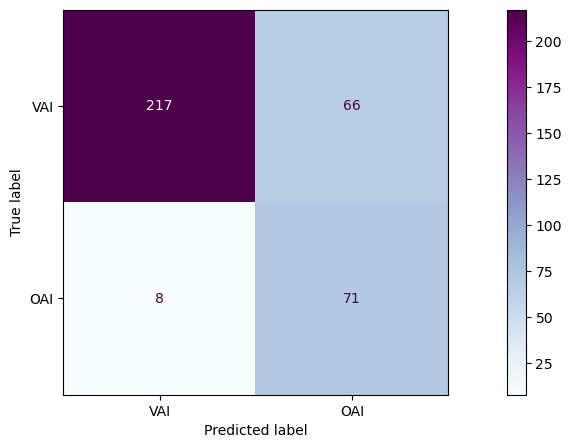

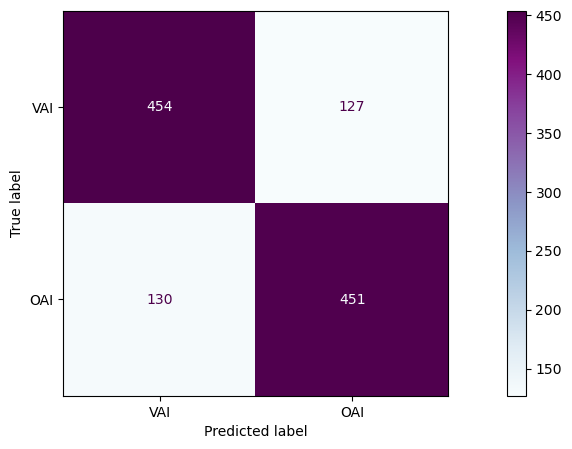

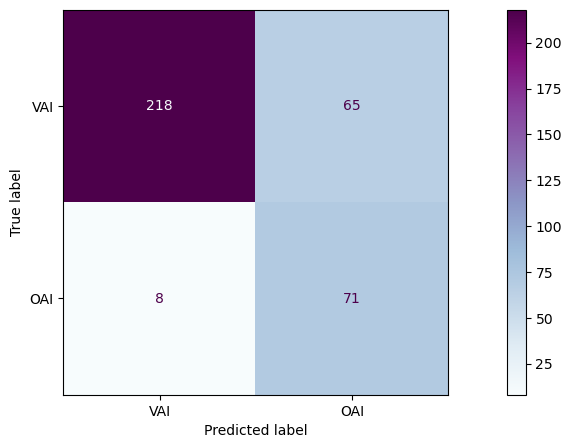

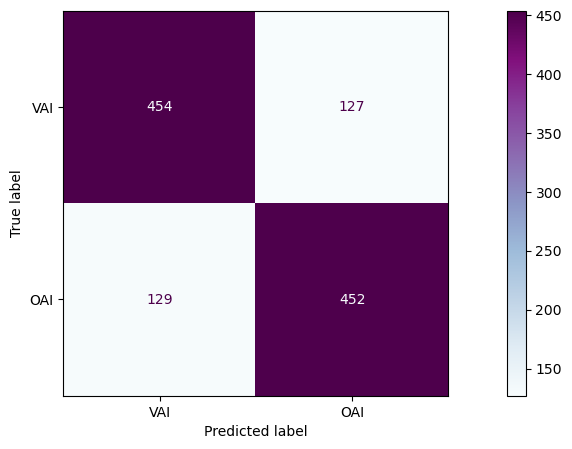

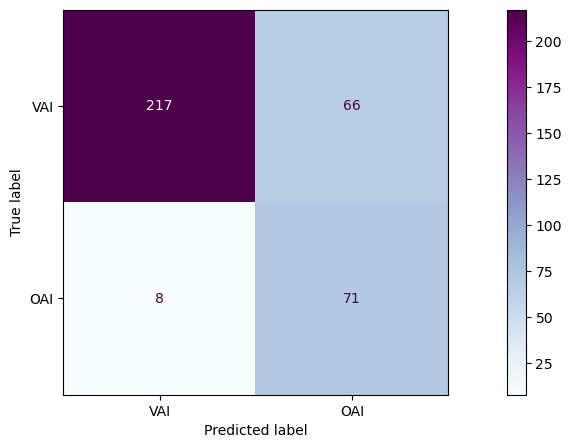

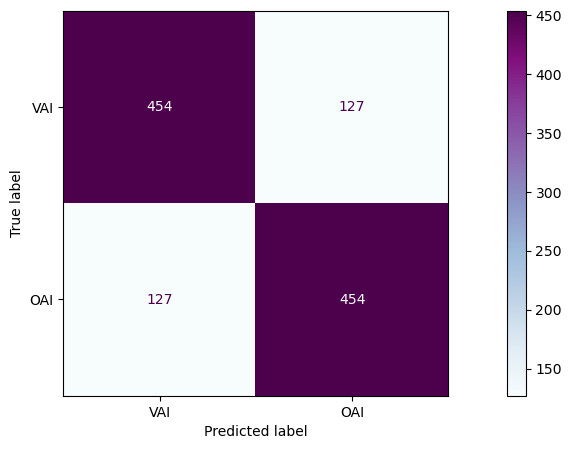

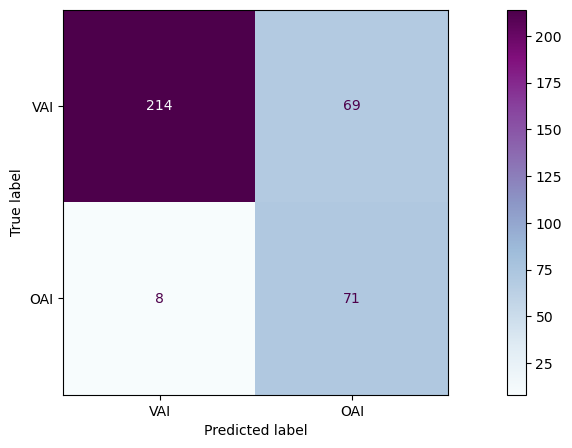

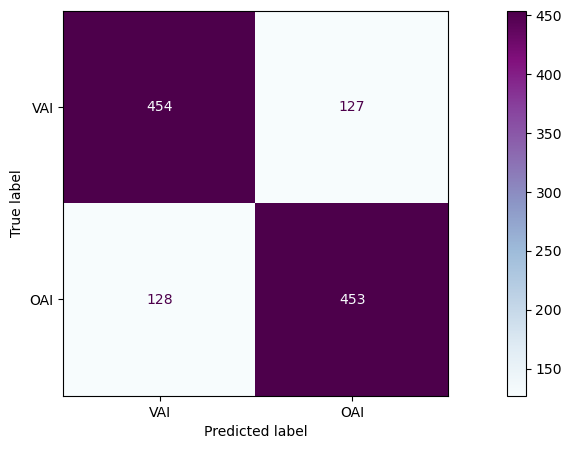

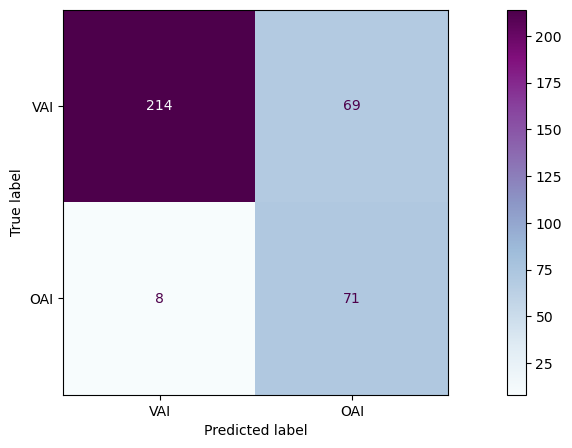

In [11]:
acc_list, f1_list, rec_list, prec_list = [],[],[],[]
for l1_ratio in np.arange(0,1,0.1):

    logreg = LogisticRegression(max_iter=10000, penalty='elasticnet',solver='saga',l1_ratio=l1_ratio)
    logreg.fit(X_ds_train,y_ds_train)
    y_train_pred = logreg.predict(X_ds_train)
    y_test_pred = logreg.predict(X_test)
    acc, f1, rec, prec = make_results(y_ds_train,y_train_pred)
    acc, f1, rec, prec = make_results(y_test,y_test_pred)
    acc_list.append(acc); f1_list.append(f1); rec_list.append(rec); prec_list.append(prec)

(0.0, 1.0)

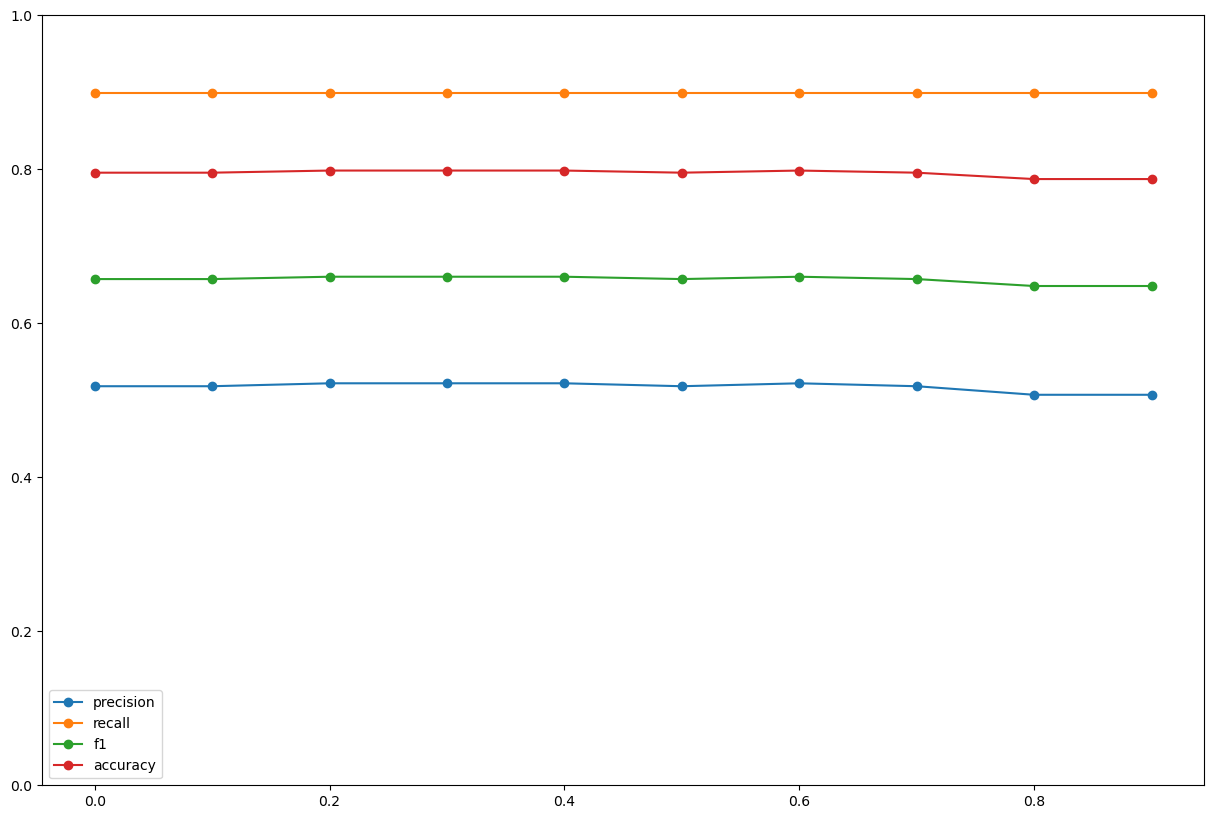

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(np.arange(0,1,0.1), prec_list,marker='o',label='precision')
ax.plot(np.arange(0,1,0.1), rec_list,marker='o',label='recall')
ax.plot(np.arange(0,1,0.1), f1_list,marker='o',label='f1')
ax.plot(np.arange(0,1,0.1), acc_list,marker='o',label='accuracy')
ax.legend(loc = 'lower left')
ax.set_ylim([0,1])

### Final

In [14]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_ds_train,y_ds_train)
y_train_pred = logreg.predict(X_ds_train)
y_test_pred = logreg.predict(X_test)

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7822719449225474
F1: 0.7824591573516767
Recall: 0.7831325301204819
Precision: 0.781786941580756


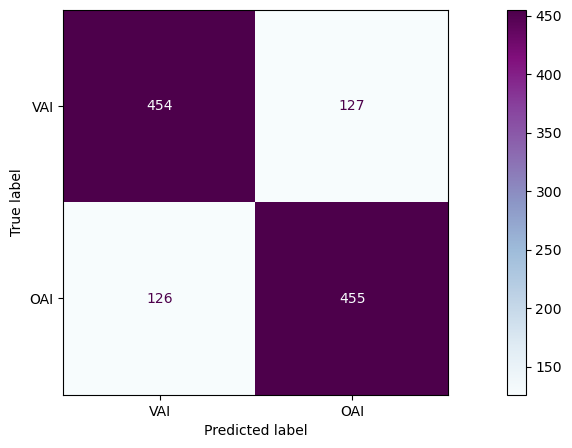

In [15]:
acc, f1, rec, prec = make_results(y_ds_train,y_train_pred)

Accuracy: 0.7955801104972375
F1: 0.6574074074074074
Recall: 0.8987341772151899
Precision: 0.5182481751824818


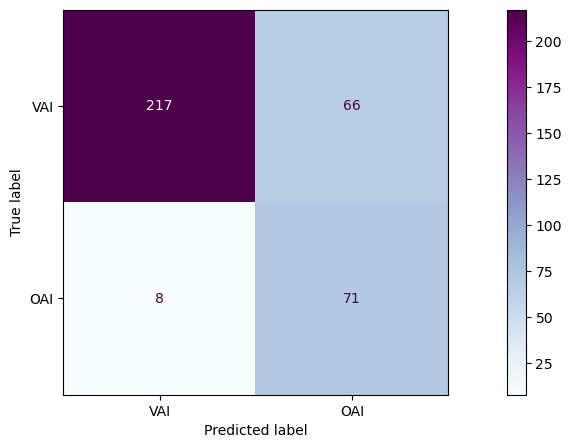

In [16]:
acc, f1, rec, prec = make_results(y_test,y_test_pred)

In [17]:
y_test_lin_pred = y_test_pred

In [18]:
date_

'03.11.2025'

In [19]:
joblib.dump(logreg,"Models\\LogReg."+date_+".joblib")

['Models\\LogReg.03.11.2025.joblib']

## RandomForest

### Tuning

In [20]:
X_rf_train, X_rf_val, y_rf_train, y_rf_val = train_test_split(X_ds_train, y_ds_train,test_size=0.15, random_state=20)

In [21]:
parameters ={ 'n_estimators':[500],
              'max_depth':[None,5,10,20,50,100],
              'bootstrap':[True,False],
              'criterion' : ['gini','entropy'],
              'max_features' : ['sqrt','log2',None,5,10]}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5)
grid_search.fit(X_ds_train,y_ds_train)

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20, 50, 100],
                         'max_features': ['sqrt', 'log2', None, 5, 10],
                         'n_estimators': [500]})

In [ ]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 5,
 'n_estimators': 500}

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7714285714285715
F1: 0.7590361445783133
Recall: 0.75
Precision: 0.7682926829268293


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7828571428571428
F1: 0.7764705882352941
Recall: 0.7857142857142857
Precision: 0.7674418604651163


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7885714285714286
F1: 0.7810650887573964
Recall: 0.7857142857142857
Precision: 0.7764705882352941


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.7906976744186046
Recall: 0.8095238095238095
Precision: 0.7727272727272727


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8114285714285714
F1: 0.8135593220338984
Recall: 0.8571428571428571
Precision: 0.7741935483870968


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8
F1: 0.8
Recall: 0.8333333333333334
Precision: 0.7692307692307693


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8
F1: 0.8
Recall: 0.8333333333333334
Precision: 0.7692307692307693


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.797752808988764
Recall: 0.8452380952380952
Precision: 0.7553191489361702


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.8
Recall: 0.8571428571428571
Precision: 0.75


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8
F1: 0.8022598870056498
Recall: 0.8452380952380952
Precision: 0.7634408602150538


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7885714285714286
F1: 0.7909604519774012
Recall: 0.8333333333333334
Precision: 0.7526881720430108


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8114285714285714
F1: 0.8156424581005587
Recall: 0.8690476190476191
Precision: 0.7684210526315789


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.8
Recall: 0.8571428571428571
Precision: 0.75


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.7954545454545454
Recall: 0.8333333333333334
Precision: 0.7608695652173914


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.7954545454545454
Recall: 0.8333333333333334
Precision: 0.7608695652173914


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7771428571428571
F1: 0.7821229050279329
Recall: 0.8333333333333334
Precision: 0.7368421052631579


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.7954545454545454
Recall: 0.8333333333333334
Precision: 0.7608695652173914


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7885714285714286
F1: 0.7909604519774012
Recall: 0.8333333333333334
Precision: 0.7526881720430108


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.7954545454545454
Recall: 0.8333333333333334
Precision: 0.7608695652173914


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7771428571428571
F1: 0.7821229050279329
Recall: 0.8333333333333334
Precision: 0.7368421052631579


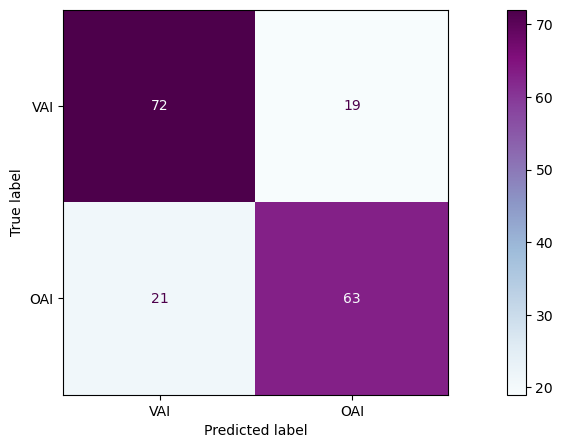

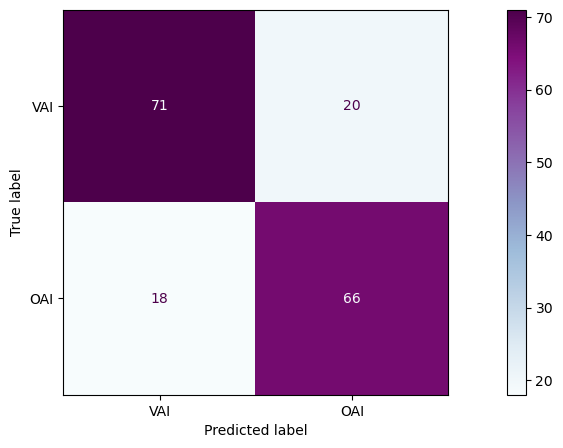

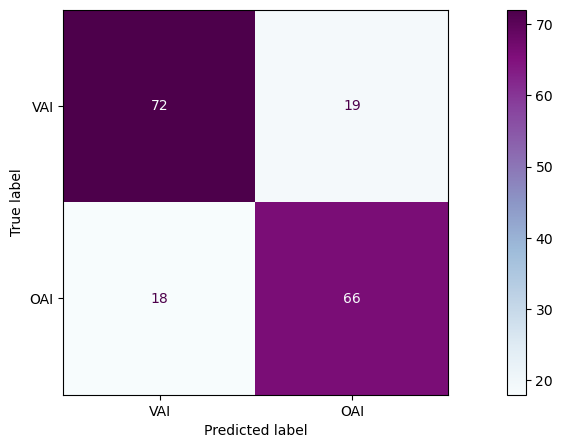

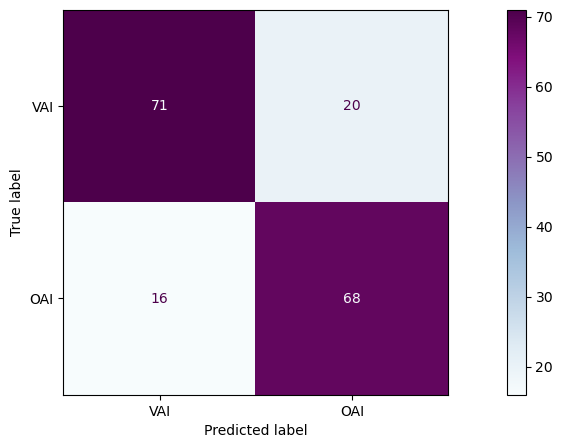

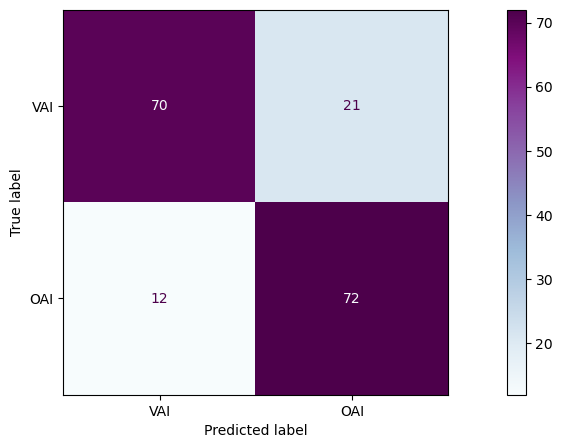

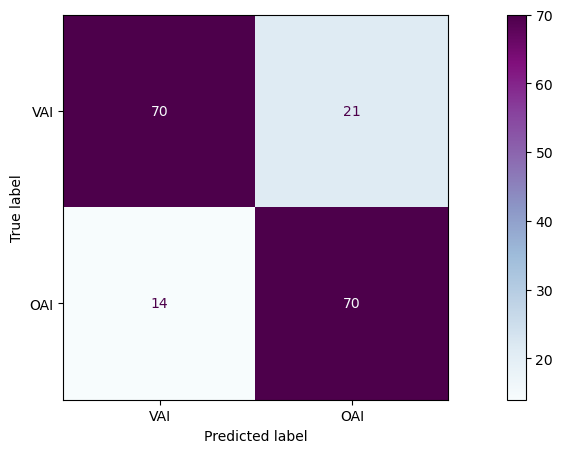

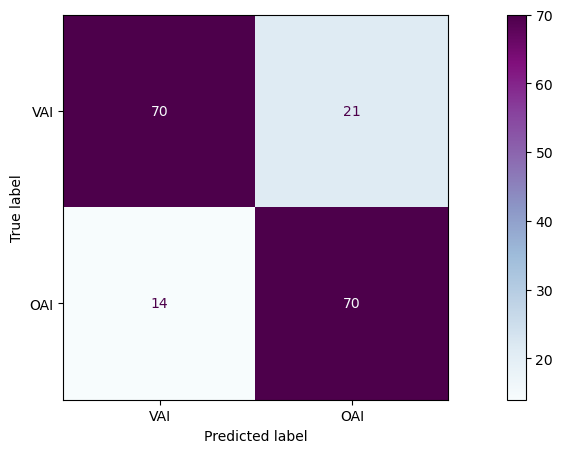

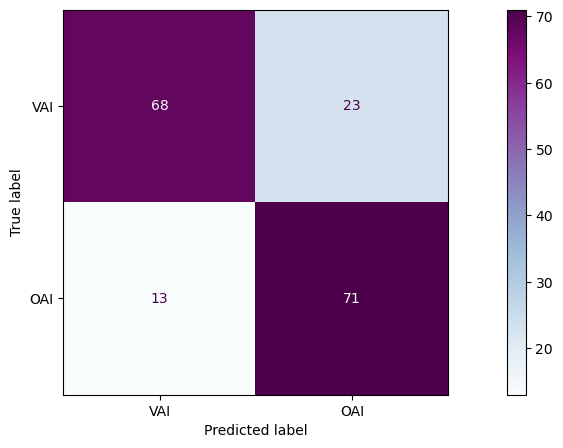

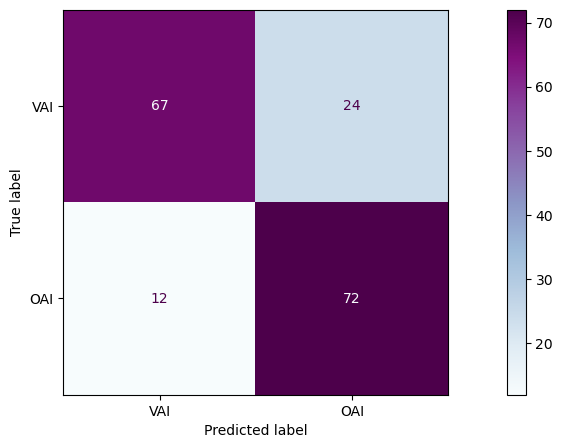

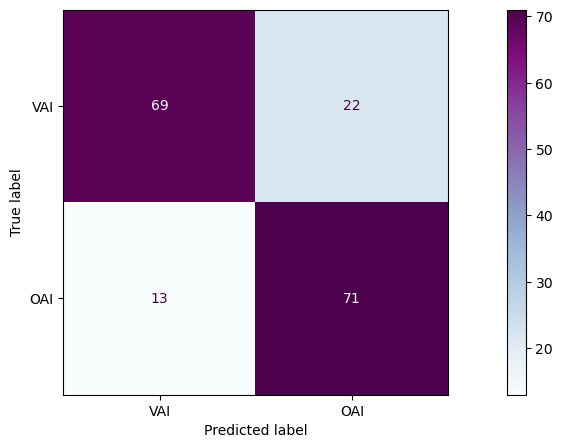

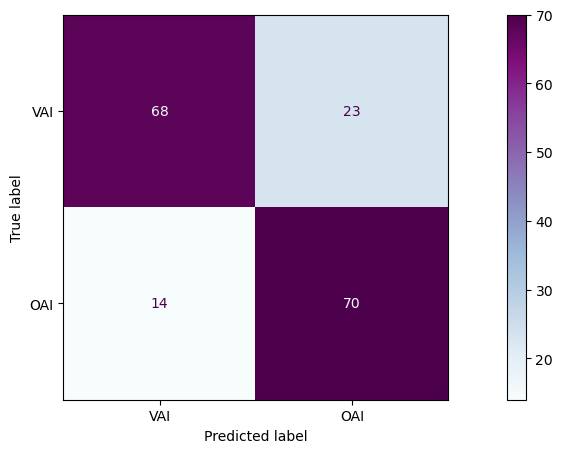

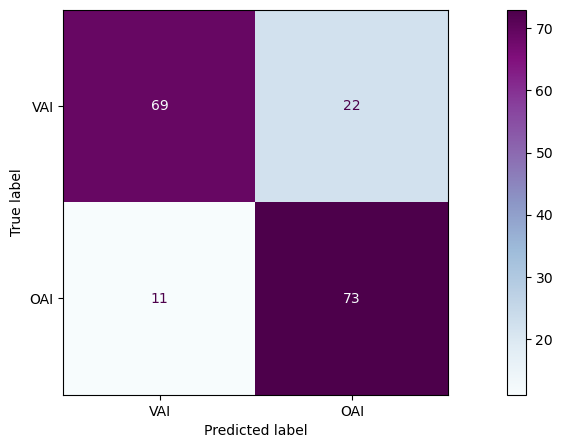

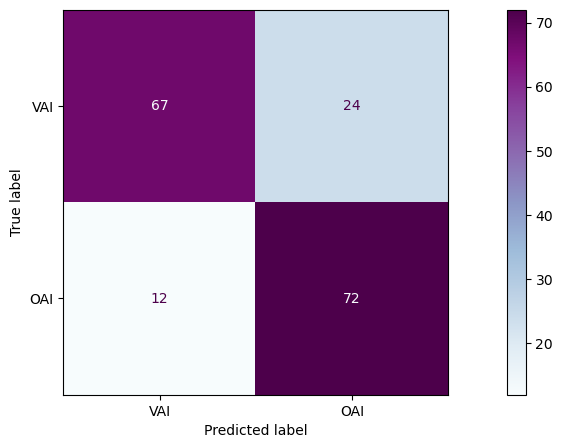

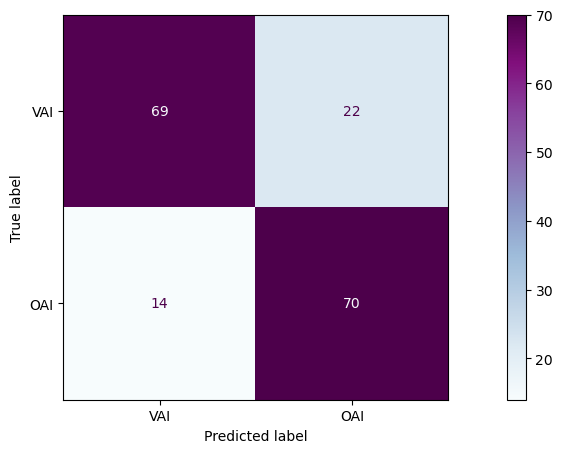

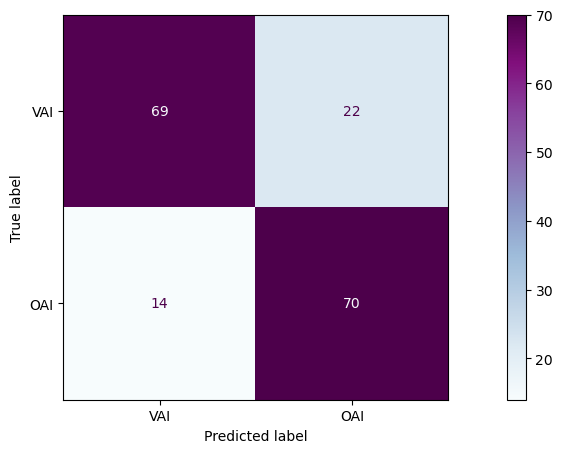

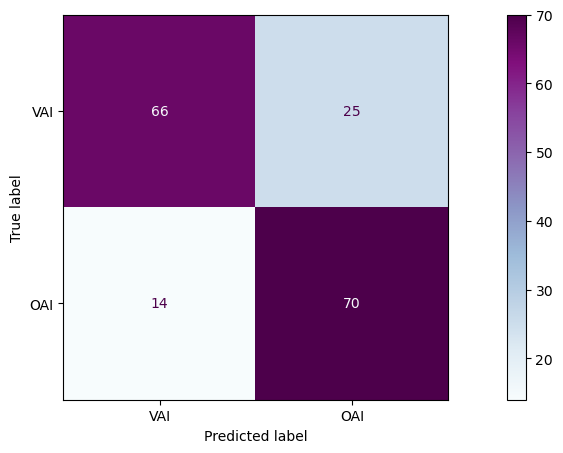

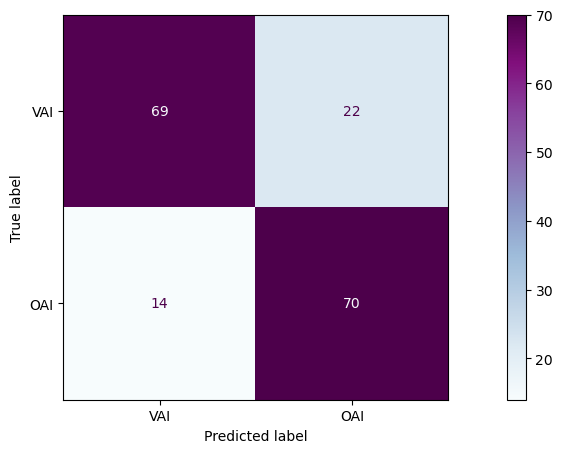

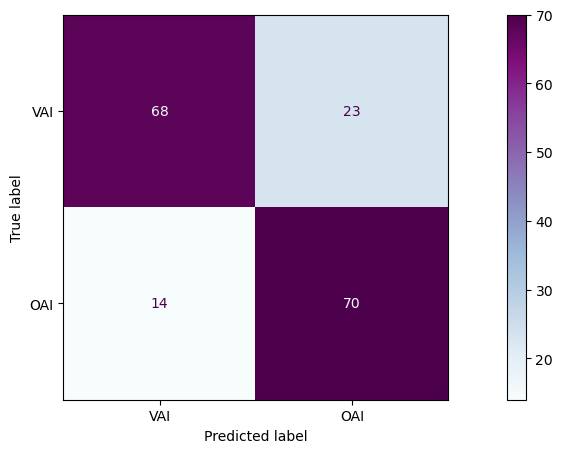

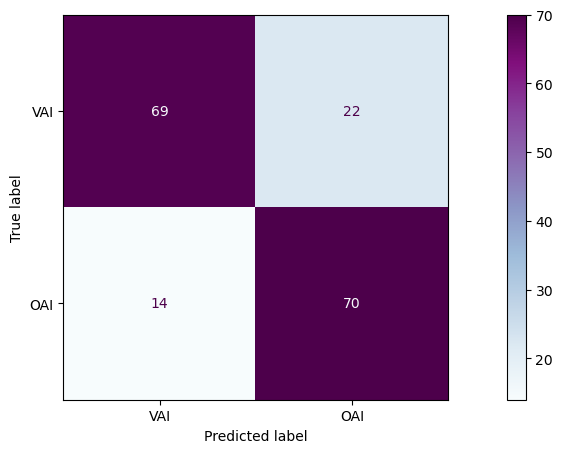

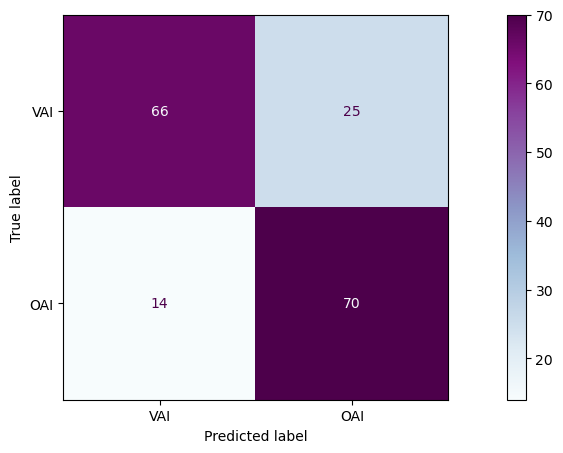

In [ ]:
acc_list, f1_list, rec_list, prec_list = [],[],[],[]

for max_depth in range(2,100,5):

    rfc = RandomForestClassifier(n_estimators=500,
                                    bootstrap=True,
                                    criterion='gini',
                                    max_depth=max_depth,
                                    max_features = 'log2',
                                    class_weight={0:1,1:1.})
    rfc.fit(X_rf_train,y_rf_train)
    #y_train_pred = rfc.predict(X_ds_train)
    y_rf_val_pred = rfc.predict(X_rf_val)
    acc, f1, rec, prec = make_results(y_rf_val,y_rf_val_pred)
    acc_list.append(acc); f1_list.append(f1); rec_list.append(rec); prec_list.append(prec)

(0.0, 1.0)

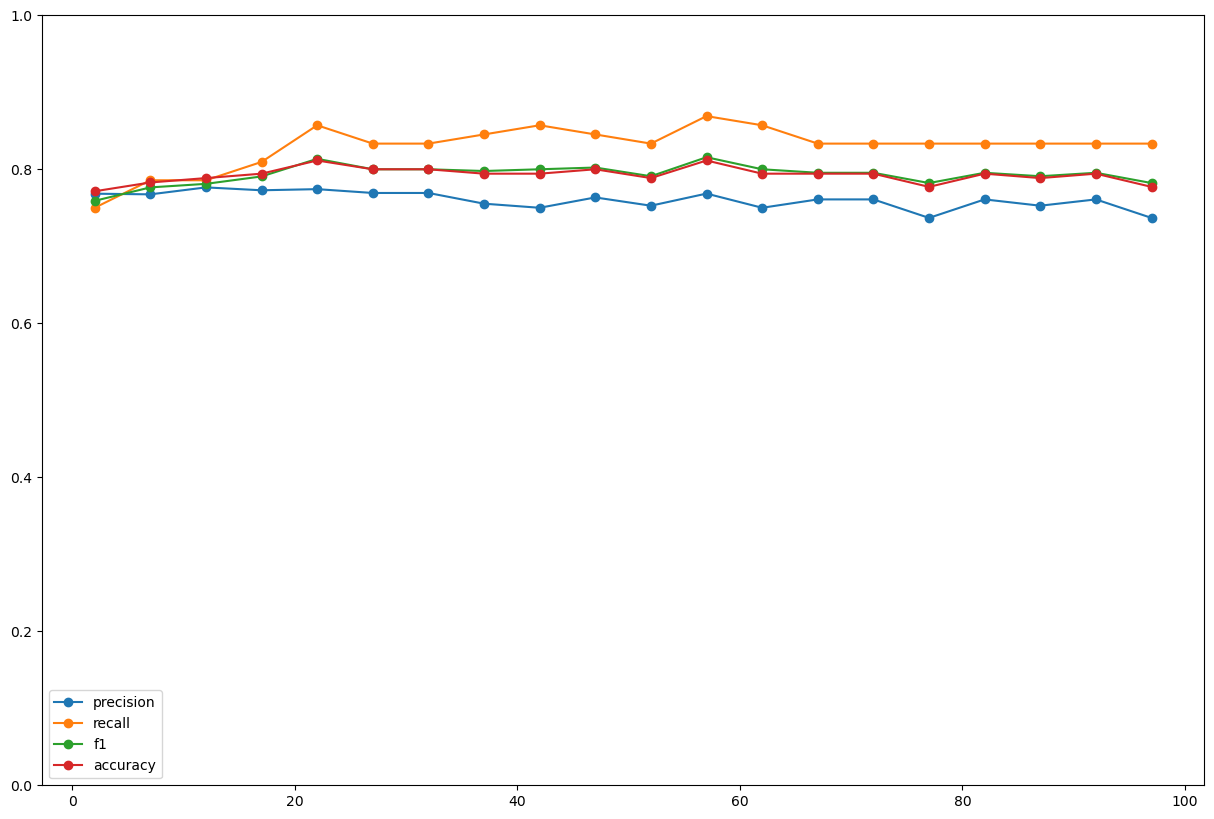

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(np.arange(2,100,5), prec_list,marker='o',label='precision')
ax.plot(np.arange(2,100,5), rec_list,marker='o',label='recall')
ax.plot(np.arange(2,100,5), f1_list,marker='o',label='f1')
ax.plot(np.arange(2,100,5), acc_list,marker='o',label='accuracy')
ax.legend(loc = 'lower left')
ax.set_ylim([0,1])

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8
F1: 0.7904191616766467
Recall: 0.7857142857142857
Precision: 0.7951807228915663


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7885714285714286
F1: 0.7909604519774012
Recall: 0.8333333333333334
Precision: 0.7526881720430108


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8057142857142857
F1: 0.8068181818181818
Recall: 0.8452380952380952
Precision: 0.7717391304347826


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7885714285714286
F1: 0.7909604519774012
Recall: 0.8333333333333334
Precision: 0.7526881720430108


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8
F1: 0.8
Recall: 0.8333333333333334
Precision: 0.7692307692307693


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8114285714285714
F1: 0.8114285714285714
Recall: 0.8452380952380952
Precision: 0.7802197802197802


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8114285714285714
F1: 0.8114285714285714
Recall: 0.8452380952380952
Precision: 0.7802197802197802


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.797752808988764
Recall: 0.8452380952380952
Precision: 0.7553191489361702


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.797752808988764
Recall: 0.8452380952380952
Precision: 0.7553191489361702


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8171428571428572
F1: 0.8160919540229885
Recall: 0.8452380952380952
Precision: 0.7888888888888889


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8057142857142857
F1: 0.8068181818181818
Recall: 0.8452380952380952
Precision: 0.7717391304347826


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.797752808988764
Recall: 0.8452380952380952
Precision: 0.7553191489361702


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.797752808988764
Recall: 0.8452380952380952
Precision: 0.7553191489361702


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8
F1: 0.8022598870056498
Recall: 0.8452380952380952
Precision: 0.7634408602150538


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8
F1: 0.8022598870056498
Recall: 0.8452380952380952
Precision: 0.7634408602150538


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8
F1: 0.8022598870056498
Recall: 0.8452380952380952
Precision: 0.7634408602150538


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7885714285714286
F1: 0.7932960893854749
Recall: 0.8452380952380952
Precision: 0.7473684210526316


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7828571428571428
F1: 0.7865168539325843
Recall: 0.8333333333333334
Precision: 0.7446808510638298


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.7954545454545454
Recall: 0.8333333333333334
Precision: 0.7608695652173914


c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7942857142857143
F1: 0.797752808988764
Recall: 0.8452380952380952
Precision: 0.7553191489361702


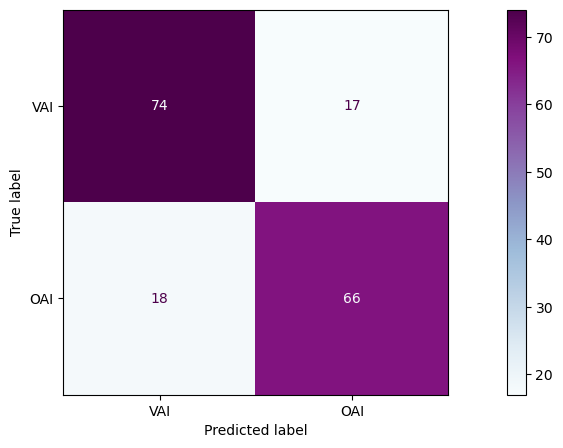

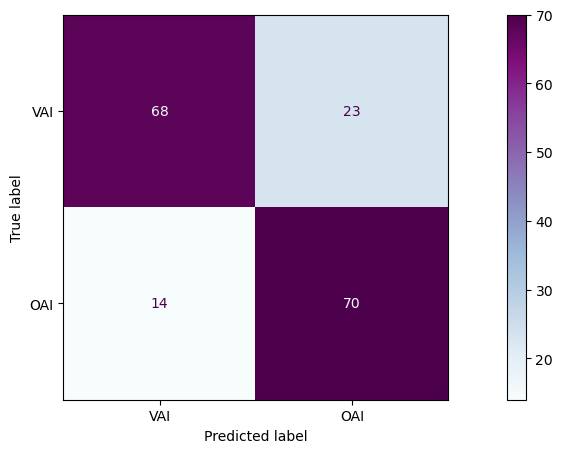

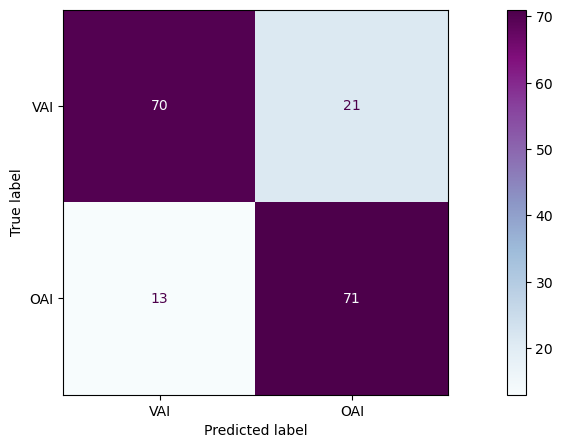

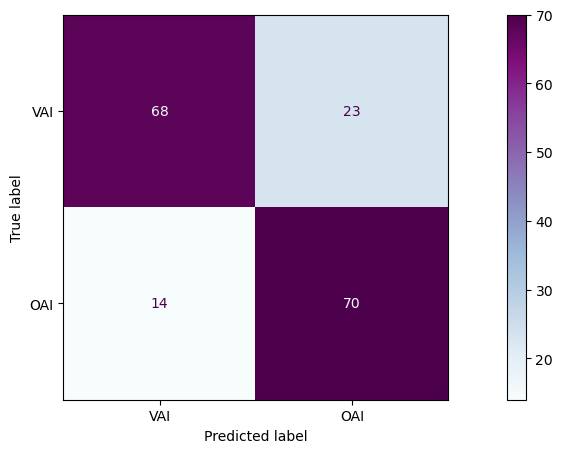

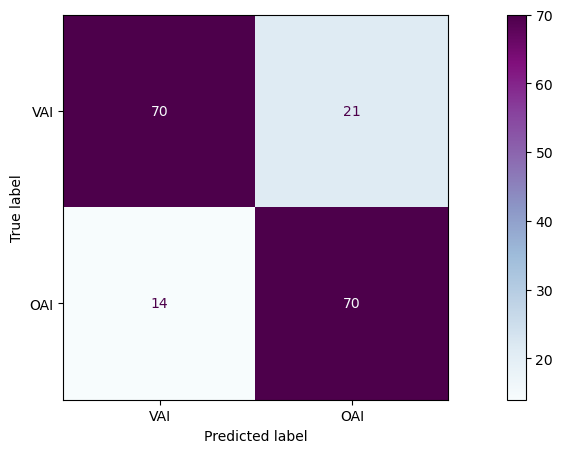

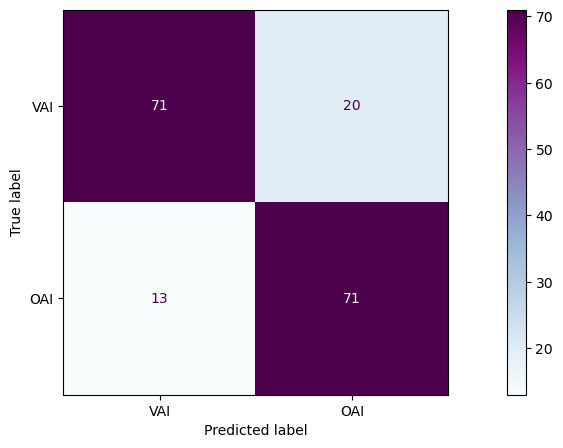

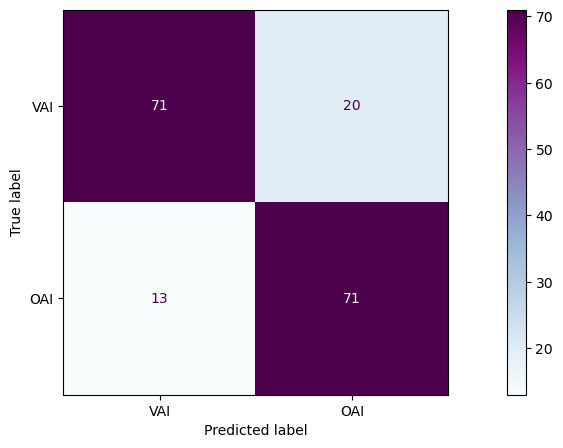

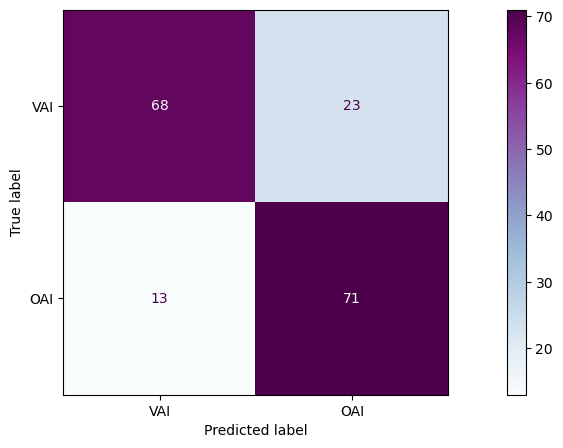

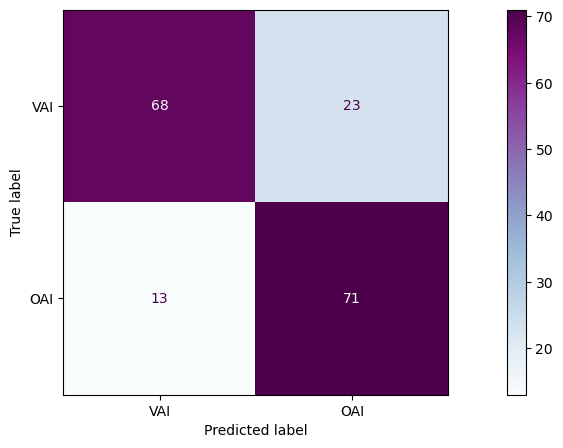

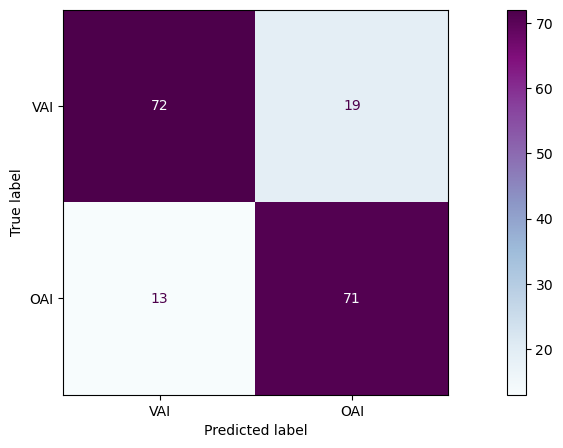

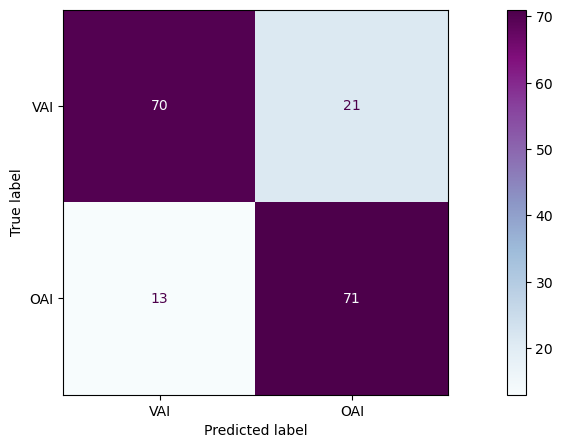

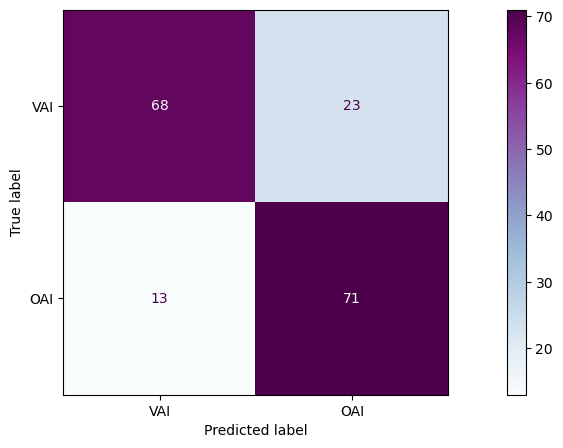

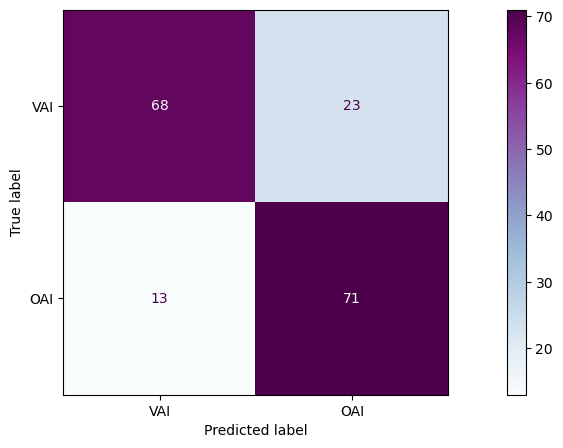

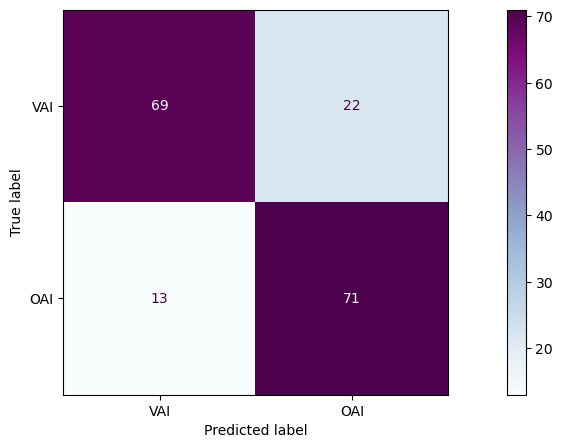

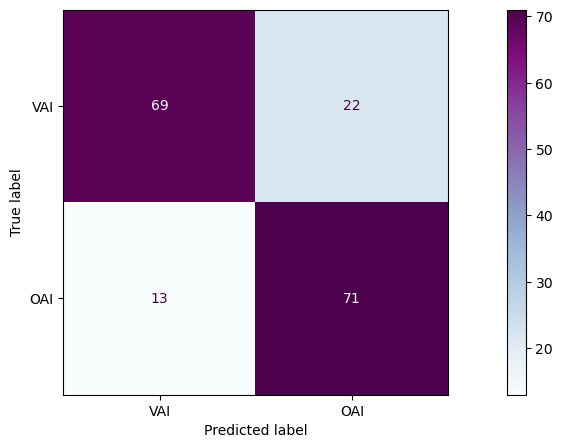

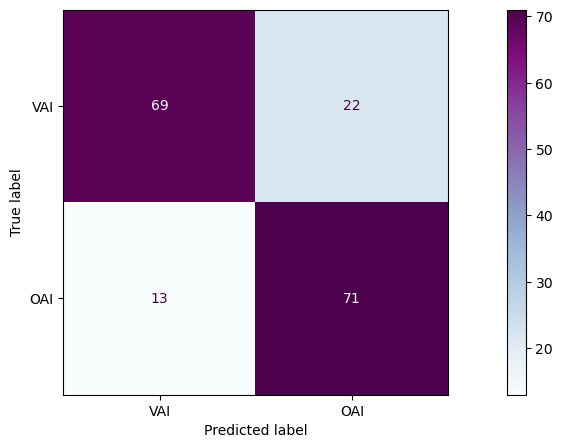

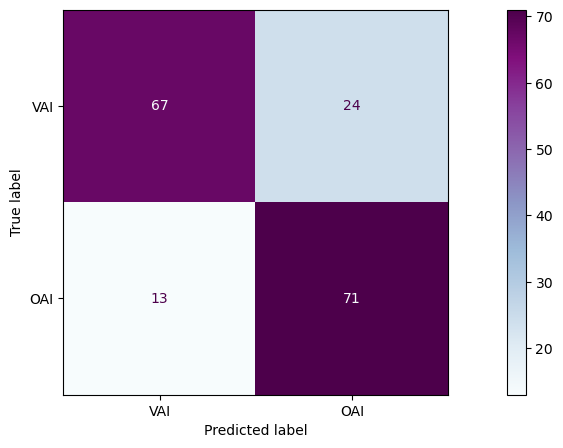

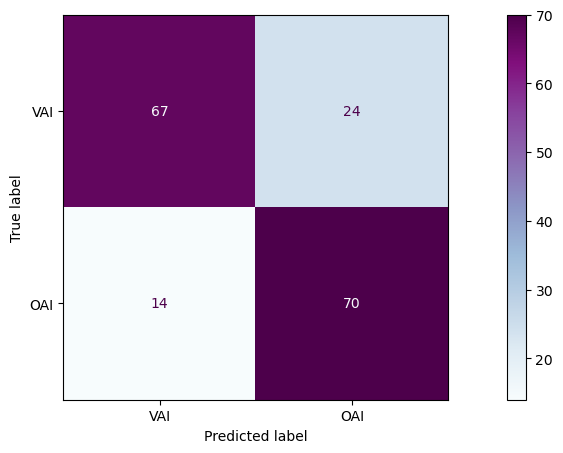

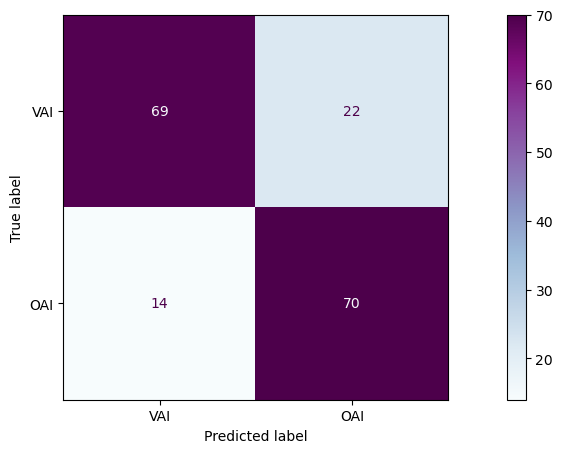

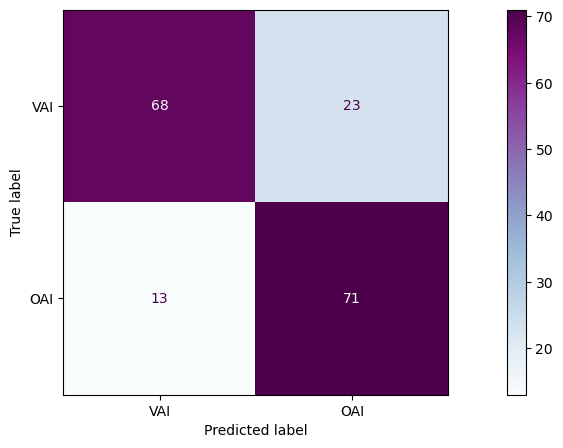

In [ ]:
acc_list, f1_list, rec_list, prec_list = [],[],[],[]

for max_f in range(2,100,5):

    rfc = RandomForestClassifier(n_estimators=500,
                                    bootstrap=True,
                                    criterion='gini',
                                    max_depth=20,
                                    max_features = max_f,
                                    class_weight={0:1,1:1.})
    rfc.fit(X_rf_train,y_rf_train)
    #y_train_pred = rfc.predict(X_ds_train)
    y_rf_val_pred = rfc.predict(X_rf_val)
    acc, f1, rec, prec = make_results(y_rf_val,y_rf_val_pred)
    acc_list.append(acc); f1_list.append(f1); rec_list.append(rec); prec_list.append(prec)

(0.0, 1.0)

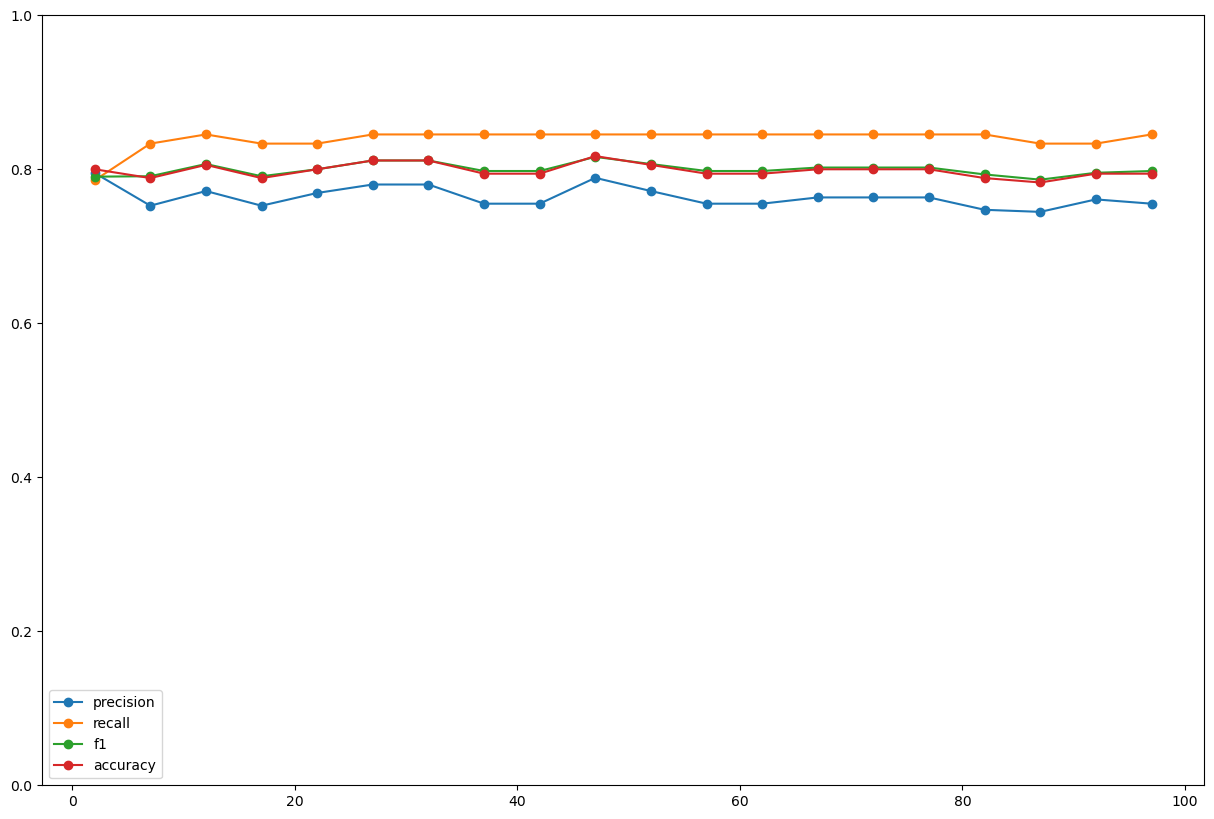

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(np.arange(2,100,5), prec_list,marker='o',label='precision')
ax.plot(np.arange(2,100,5), rec_list,marker='o',label='recall')
ax.plot(np.arange(2,100,5), f1_list,marker='o',label='f1')
ax.plot(np.arange(2,100,5), acc_list,marker='o',label='accuracy')
ax.legend(loc = 'lower left')
ax.set_ylim([0,1])

### Final

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8209982788296041
F1: 0.8162544169611308
Recall: 0.7951807228915663
Precision: 0.838475499092559


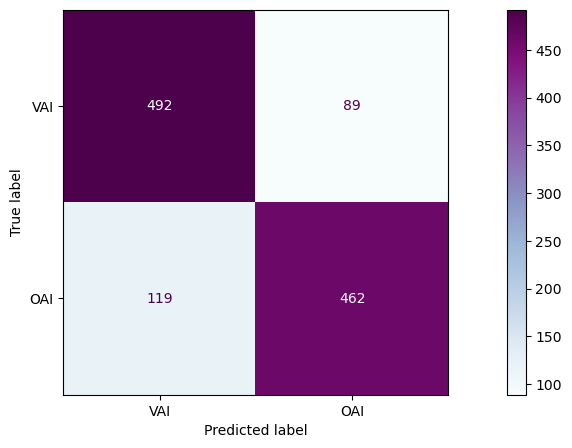

In [26]:
rfc = RandomForestClassifier(n_estimators=500,
                                bootstrap=True,
                                criterion='gini',
                                max_depth=10,
                                max_features = 'log2',
                                class_weight={0:1,1:1.},
                                max_leaf_nodes = 150,
                                random_state = 20)
rfc.fit(X_ds_train,y_ds_train)
y_train_pred = rfc.predict(X_ds_train)
y_test_pred = rfc.predict(X_test)
acc, f1, rec, prec = make_results(y_ds_train,y_train_pred)

Accuracy: 0.8287292817679558
F1: 0.6868686868686869
Recall: 0.8607594936708861
Precision: 0.5714285714285714


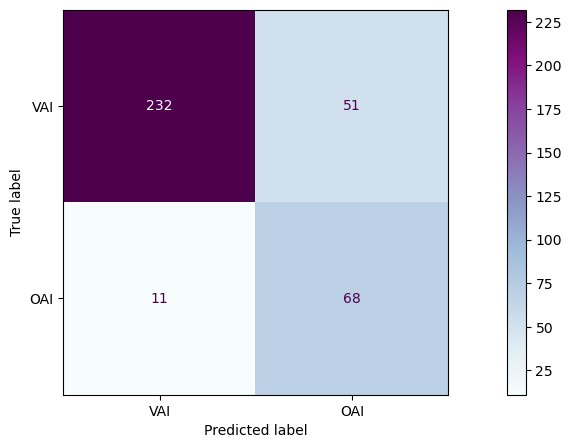

In [27]:
acc, f1, rec, prec = make_results(y_test,y_test_pred)

In [28]:
y_test_rfc_pred = y_test_pred

In [29]:
joblib.dump(rfc,"Models\\RFC."+date_+".joblib")

['Models\\RFC.03.11.2025.joblib']

## SVC

### Tuning

In [117]:
parameters ={ 'C':[1e-4,1e-3,1e-2,1e-1,1],
              'shrinking':[True,False],
              'gamma':['scale','auto'],
              'kernel':['sigmoid','rbf']}
grid_search = GridSearchCV(SVC(),parameters,cv=5)
grid_search.fit(X_ds_train,y_ds_train)

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A 

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['sigmoid', 'rbf'],
                         'shrinking': [True, False]})

In [118]:
grid_search.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.802065404475043
F1: 0.801038062283737
Recall: 0.7969018932874354
Precision: 0.8052173913043478


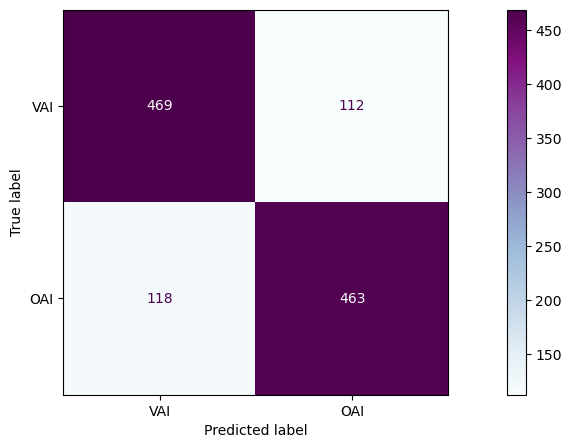

In [30]:
svc = SVC(kernel='rbf',
          C=1.5,
          shrinking=True,
          gamma = 'scale',
          probability=True)
svc.fit(X_ds_train,y_ds_train)
y_train_pred = svc.predict(X_ds_train)
y_test_pred = svc.predict(X_test)
acc, f1, rec, prec = make_results(y_ds_train,y_train_pred)

Accuracy: 0.7955801104972375
F1: 0.6636363636363637
Recall: 0.9240506329113924
Precision: 0.5177304964539007


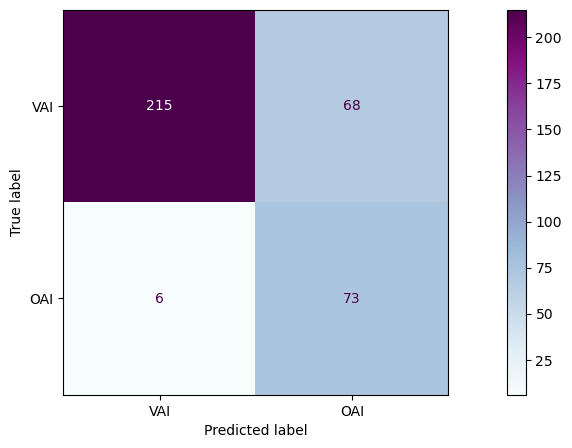

In [31]:
acc, f1, rec, prec = make_results(y_test,y_test_pred)

In [32]:
y_test_svc_pred = y_test_pred

In [33]:
joblib.dump(svc,"Models\\SVC."+date_+".joblib")

['Models\\SVC.03.11.2025.joblib']

## Stack

In [34]:
estimators = [
    ('rfc', rfc),
    ('svc', svc),
    ('log',logreg)
]
clf = StackingClassifier(estimators=estimators,final_estimator=LogisticRegression())

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Accuracy: 0.7969018932874354
F1: 0.7947826086956522
Recall: 0.7865748709122203
Precision: 0.8031634446397188


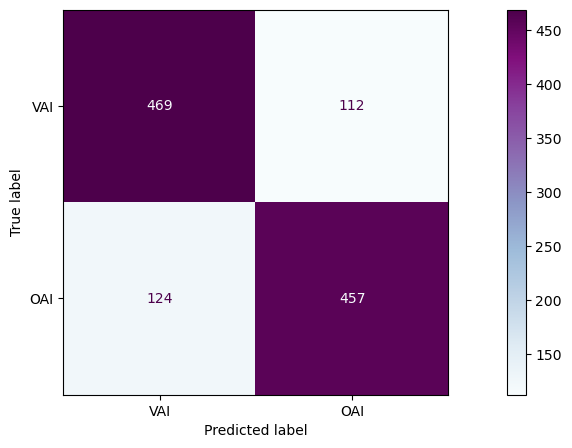

In [35]:
clf.fit(X_ds_train,y_ds_train)
y_train_pred = clf.predict(X_ds_train)
y_test_pred = clf.predict(X_test)
acc, f1, rec, prec = make_results(y_ds_train,y_train_pred)

Accuracy: 0.8149171270718232
F1: 0.6854460093896714
Recall: 0.9240506329113924
Precision: 0.5447761194029851


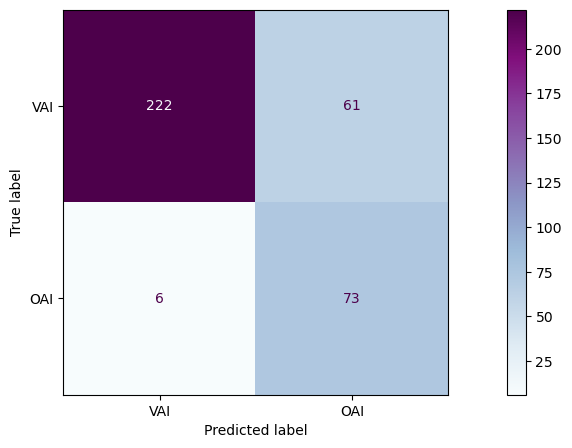

In [36]:
acc, f1, rec, prec = make_results(y_test,y_test_pred)

In [41]:
y_test_clf_pred = y_test_pred

In [42]:
joblib.dump(clf,"Models\\CLF."+date_+".joblib")

['Models\\CLF.03.11.2025.joblib']

## Vote

### Hard

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Accuracy: 0.802065404475043
F1: 0.798951048951049
Recall: 0.7865748709122203
Precision: 0.8117229129662522


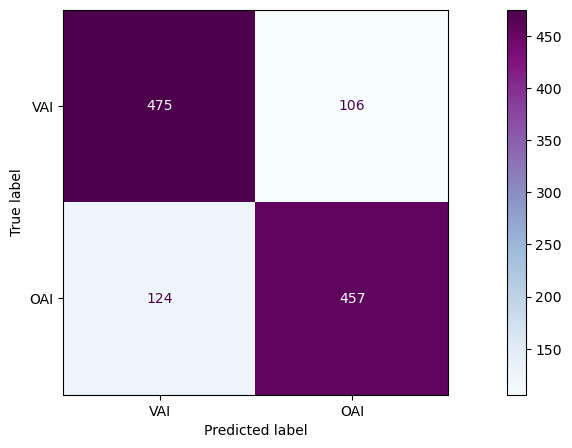

In [43]:
estimators = [
    ('rfc', rfc),
    ('svc', svc),
    ('log',logreg)
]
vote_hard = VotingClassifier(estimators=estimators,voting='hard')
vote_hard.fit(X_ds_train,y_ds_train)
y_train_pred = vote_hard.predict(X_ds_train)
y_test_pred = vote_hard.predict(X_test)
acc, f1, rec, prec = make_results(y_ds_train,y_train_pred)

Accuracy: 0.8204419889502762
F1: 0.6919431279620853
Recall: 0.9240506329113924
Precision: 0.553030303030303


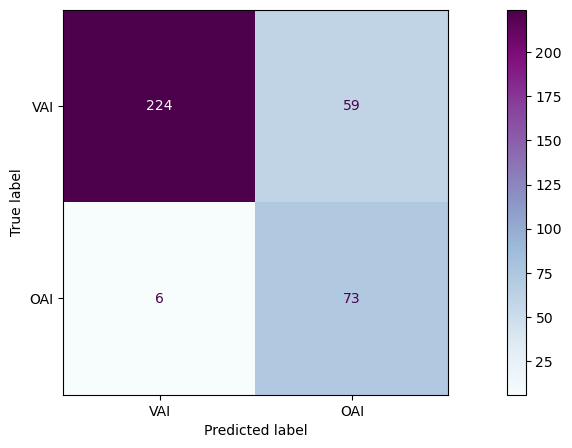

In [44]:
acc, f1, rec, prec = make_results(y_test,y_test_pred)

In [45]:
y_test_voth_pred = y_test_pred

In [46]:
joblib.dump(vote_hard,"Models\\VoteHard."+date_+".joblib")

['Models\\VoteHard.03.11.2025.joblib']

### Soft

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Accuracy: 0.8003442340791739
F1: 0.7979094076655052
Recall: 0.7882960413080895
Precision: 0.8077601410934744


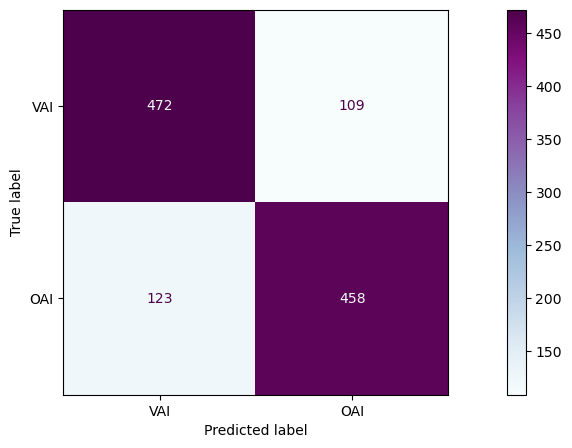

In [49]:
estimators = [
    ('rfc', rfc),
    ('svc', svc),
    ('log',logreg)
]
vote_soft = VotingClassifier(estimators=estimators,voting='soft')
vote_soft.fit(X_ds_train,y_ds_train)
y_train_pred = vote_soft.predict(X_ds_train)
y_test_pred = vote_soft.predict(X_test)
acc, f1, rec, prec = make_results(y_ds_train,y_train_pred)

Accuracy: 0.8204419889502762
F1: 0.6919431279620853
Recall: 0.9240506329113924
Precision: 0.553030303030303


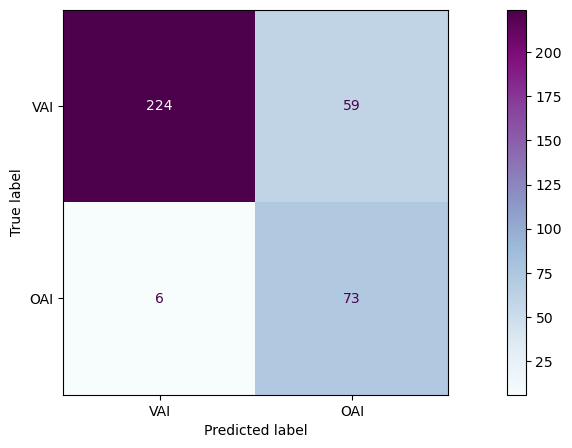

In [50]:
acc, f1, rec, prec = make_results(y_test,y_test_pred)

In [51]:
y_test_vots_pred = y_test_pred

In [52]:
joblib.dump(vote_soft,"Models\\VoteSoft."+date_+".joblib")

['Models\\VoteSoft.03.11.2025.joblib']

## Summary

Accuracy: 0.7955801104972375
F1: 0.6574074074074074
Recall: 0.8987341772151899
Precision: 0.5182481751824818
Accuracy: 0.8287292817679558
F1: 0.6868686868686869
Recall: 0.8607594936708861
Precision: 0.5714285714285714
Accuracy: 0.7955801104972375
F1: 0.6636363636363637
Recall: 0.9240506329113924
Precision: 0.5177304964539007
Accuracy: 0.8149171270718232
F1: 0.6854460093896714
Recall: 0.9240506329113924
Precision: 0.5447761194029851
Accuracy: 0.8204419889502762
F1: 0.6919431279620853
Recall: 0.9240506329113924
Precision: 0.553030303030303
Accuracy: 0.8204419889502762
F1: 0.6919431279620853
Recall: 0.9240506329113924
Precision: 0.553030303030303


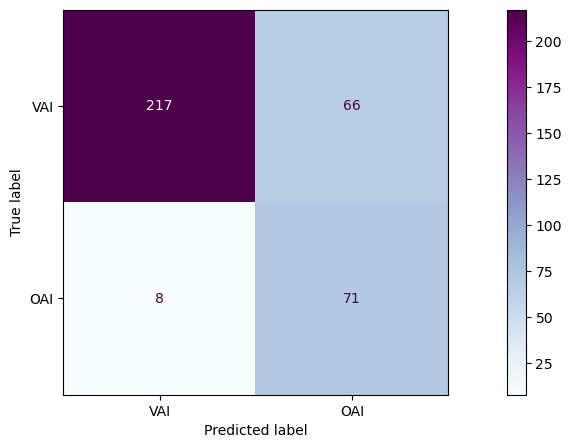

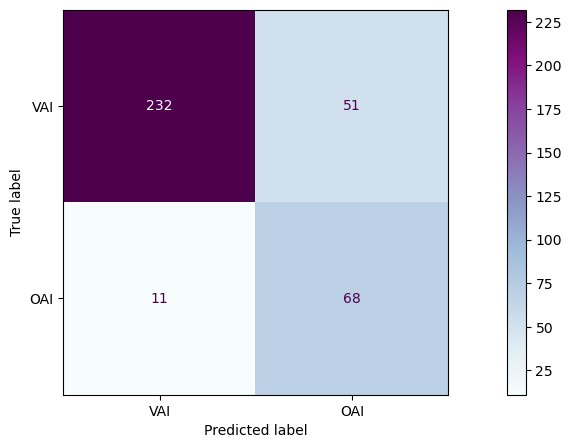

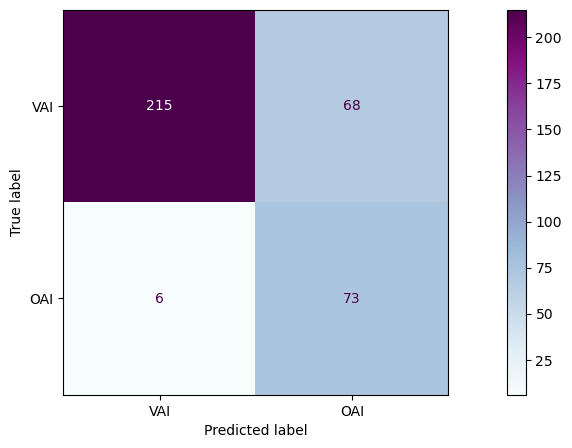

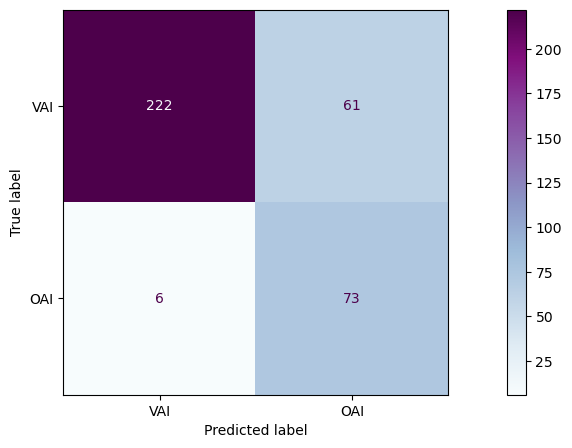

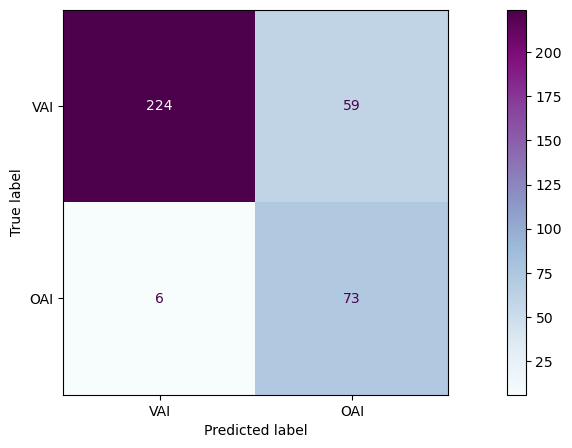

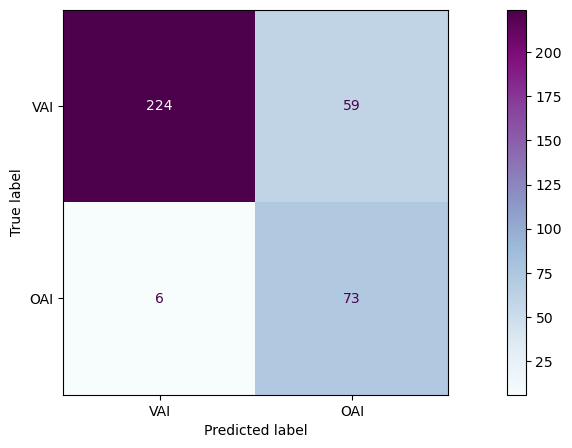

In [53]:
acc_list, f1_list, rec_list, prec_list = [],[],[],[]
for mod in [y_test_lin_pred, y_test_rfc_pred, y_test_svc_pred, y_test_clf_pred, y_test_voth_pred, y_test_vots_pred]:

    acc, f1, rec, prec = make_results(y_test,mod)
    acc_list.append(acc); f1_list.append(f1); rec_list.append(rec); prec_list.append(prec)

summary_df = pd.DataFrame(data = zip(acc_list, f1_list, rec_list, prec_list),
                          columns = ['Accuracy',' F1','Recall','Precision'],
                          index = ['LIN','RFC','SVC','CLF','VOTEHARD','VOTESOFT'])

In [54]:
summary_df

,Accuracy,F1,Recall,Precision
LIN,0.795580,0.657407,0.898734,0.518248
RFC,0.828729,0.686869,0.860759,0.571429
SVC,0.795580,0.663636,0.924051,0.517730
CLF,0.814917,0.685446,0.924051,0.544776
VOTEHARD,0.820442,0.691943,0.924051,0.553030
VOTESOFT,0.820442,0.691943,0.924051,0.553030


# Full Sample

### NN

In [93]:
nn = keras.Sequential([layers.Flatten(input_shape = (X_train.shape[1],)),
                        layers.Dense(X_train.shape[1],activation='relu'),
                       layers.Dense(1,activation='sigmoid')])

In [94]:
nn.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

In [95]:
history = nn.fit(X_train, y_train, epochs=10, batch_size=25,validation_split=0.1,class_weight = {0: 1,1: 3.5})

Epoch 1/10
99/99 [==============================] - 1s 4ms/step - loss: 1.0020 - accuracy: 0.6500 - val_loss: 0.6269 - val_accuracy: 0.7372
Epoch 2/10
99/99 [==============================] - 0s 2ms/step - loss: 0.8983 - accuracy: 0.7272 - val_loss: 0.5758 - val_accuracy: 0.7482
Epoch 3/10
99/99 [==============================] - 0s 2ms/step - loss: 0.8375 - accuracy: 0.7305 - val_loss: 0.5351 - val_accuracy: 0.7737
Epoch 4/10
99/99 [==============================] - 0s 2ms/step - loss: 0.7998 - accuracy: 0.7451 - val_loss: 0.5043 - val_accuracy: 0.7883
Epoch 5/10
99/99 [==============================] - 0s 2ms/step - loss: 0.7762 - accuracy: 0.7520 - val_loss: 0.4864 - val_accuracy: 0.7920
Epoch 6/10
99/99 [==============================] - 0s 2ms/step - loss: 0.7601 - accuracy: 0.7528 - val_loss: 0.4732 - val_accuracy: 0.8029
Epoch 7/10
99/99 [==============================] - 0s 2ms/step - loss: 0.7491 - accuracy: 0.7610 - val_loss: 0.4640 - val_accuracy: 0.7993
Epoch 8/10
99/99 [==

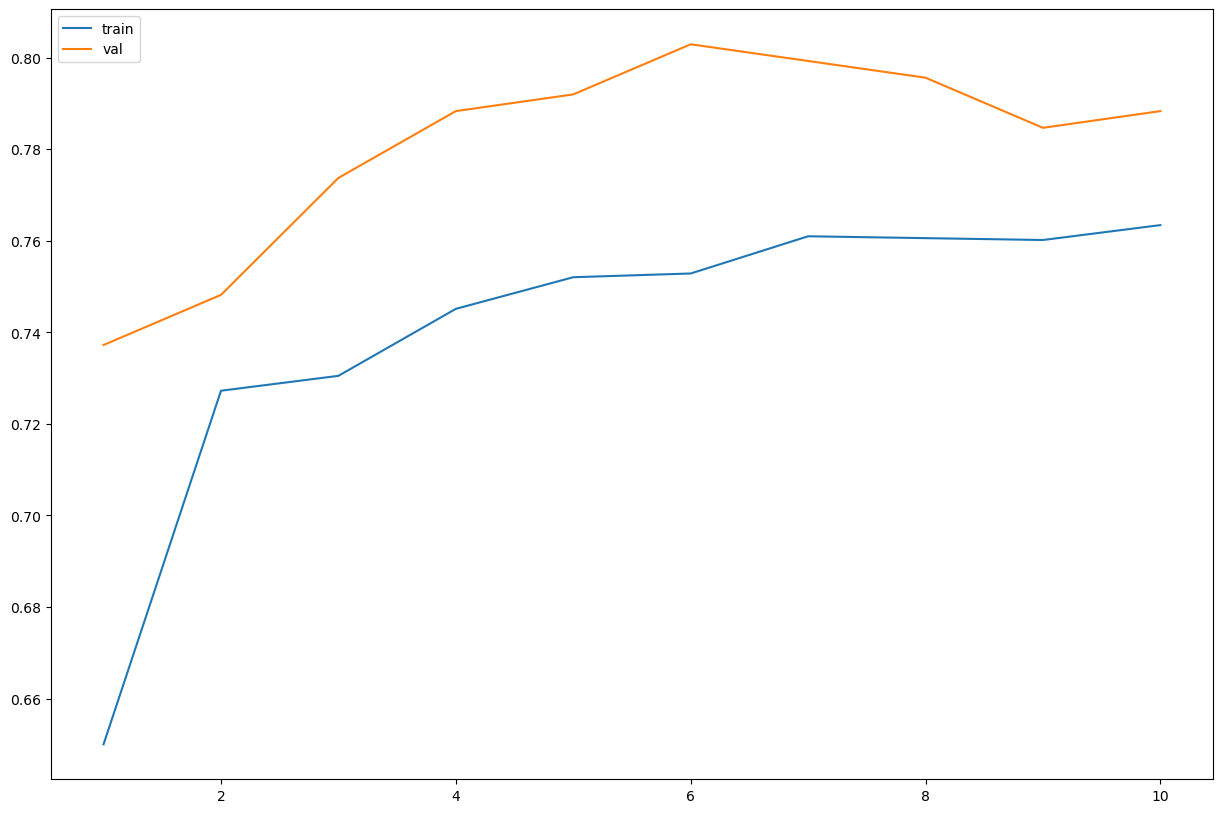

In [96]:
plt.figure(figsize=(15,10))
plt.plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'],label='train')
plt.plot(range(1,len(history.history['accuracy'])+1),history.history['val_accuracy'],label='val')
plt.legend(loc= 'upper left')

12/12 [==============================] - 0s 1ms/step
Accuracy: 0.7845303867403315
F1: 0.6388888888888888
Recall: 0.8734177215189873
Precision: 0.5036496350364964


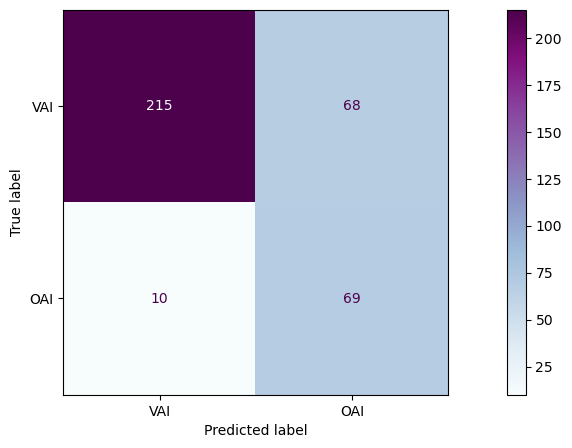

In [99]:
y_test_pred = []
y_test_prob = nn.predict(X_test)
for i in range(len(y_test_prob)):
    if y_test_prob[i] > 0.5:
        y_test_pred.append(1)
    else:
        y_test_pred.append(0)
acc, f1, rec, prec = make_results(y_test,y_test_pred)

(array([34., 25., 37., 24., 13., 19., 16., 13., 21., 20., 15., 11., 12.,
        11., 16., 14., 23., 17., 16.,  5.]),
 array([0.01483478, 0.06255418, 0.11027358, 0.15799299, 0.20571239,
        0.2534318 , 0.30115119, 0.34887061, 0.39658999, 0.44430941,
        0.4920288 , 0.53974819, 0.58746761, 0.63518703, 0.68290645,
        0.73062581, 0.77834523, 0.82606465, 0.87378407, 0.92150342,
        0.96922284]),
 <BarContainer object of 20 artists>)

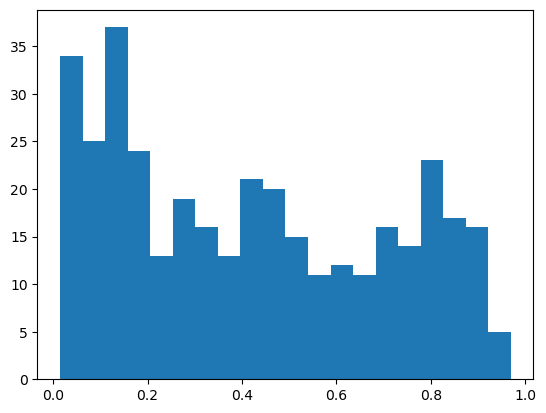

In [100]:
plt.hist(y_test_prob,bins = 20)

## XGB

In [64]:
parameters ={ 'max_depth' : [None, 5,10,50,100],
             'learning_rate':[0.01,0.1,0.25,0.5,0.75],
             'gamma':[0,1,10,50,100],
             'scale_pos_weight':[3.7]}
grid_search = GridSearchCV(XGBClassifier(),parameters,cv=5)
grid_search.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

{'gamma': 0, 'learning_rate': 0.75, 'max_depth': 10, 'scale_pos_weight': 3.7}

Accuracy: 0.8046817849305048
F1: 0.6468253968253969
Recall: 0.8416523235800344
Precision: 0.5252416756176155


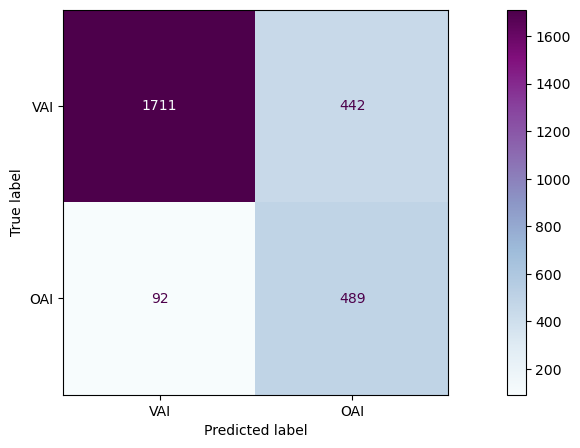

In [65]:
xgb = XGBClassifier(scale_pos_weight = 3.7,learning_rate = 0.25,max_depth = 10,gamma=10)
xgb.fit(X_train,y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
acc, f1, rec, prec = make_results(y_train,y_train_pred)

Accuracy: 0.7679558011049724
F1: 0.625
Recall: 0.8860759493670886
Precision: 0.4827586206896552


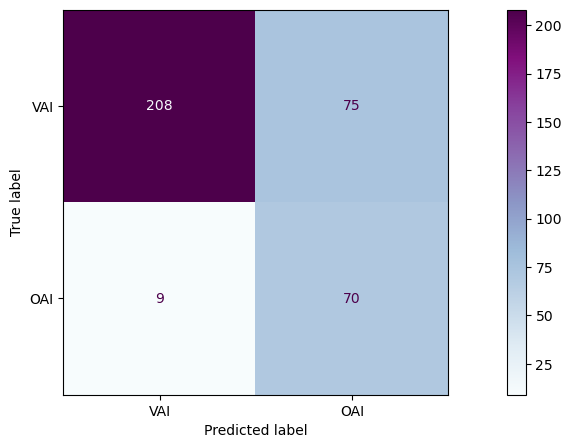

In [66]:
acc, f1, rec, prec = make_results(y_test,y_test_pred)

(array([87., 36., 30.,  4.,  2.,  8.,  2., 14., 18., 14.,  8., 17.,  9.,
         3., 11., 16., 16.,  3., 43., 21.]),
 array([0.04358741, 0.08731383, 0.13104026, 0.17476667, 0.2184931 ,
        0.26221952, 0.30594593, 0.34967238, 0.39339879, 0.43712521,
        0.48085162, 0.52457803, 0.56830448, 0.61203092, 0.65575731,
        0.69948375, 0.74321014, 0.78693658, 0.83066303, 0.87438941,
        0.91811585]),
 <BarContainer object of 20 artists>)

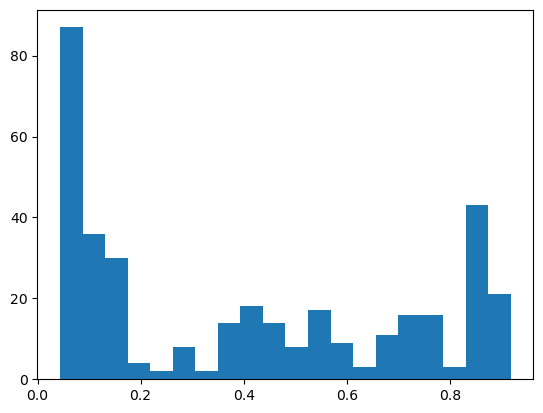

In [305]:
plt.hist(xgb.predict_proba(X_test)[:,1],bins=20)

## RFC

c:\Users\christopher.johnson\Anaconda3\envs\Py310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.825164594001463
F1: 0.7078239608801956
Recall: 0.9965576592082617
Precision: 0.5488151658767773


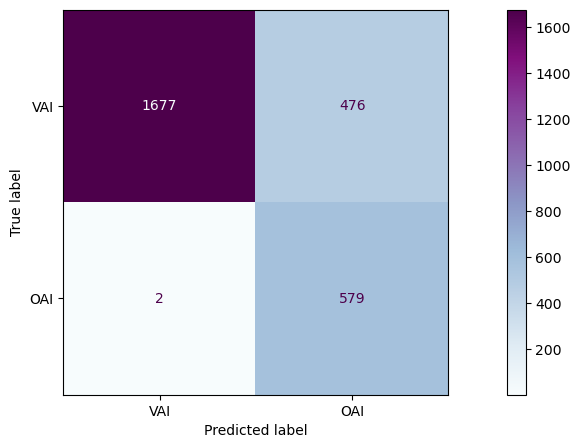

In [67]:
rfc_full = RandomForestClassifier(n_estimators=500,
                                bootstrap=True,
                                criterion='gini',
                                max_depth=None,
                                max_features = 200,
                                class_weight={0:1,1:2.},
                                max_leaf_nodes =200,
                                random_state = 20)
rfc_full.fit(X_ds_train,y_ds_train)
y_train_pred = rfc_full.predict(X_train)
y_test_pred = rfc_full.predict(X_test)
acc, f1, rec, prec = make_results(y_train,y_train_pred)

Accuracy: 0.7348066298342542
F1: 0.5932203389830508
Recall: 0.8860759493670886
Precision: 0.445859872611465


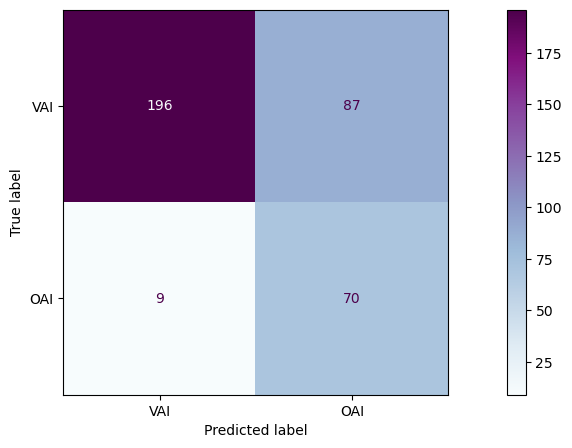

In [68]:
acc, f1, rec, prec = make_results(y_test,y_test_pred)

(array([118.,  18.,   7.,   3.,   6.,   9.,   6.,  13.,  13.,  17.,  13.,
         16.,  16.,  14.,  14.,  14.,  16.,   9.,  18.,  22.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

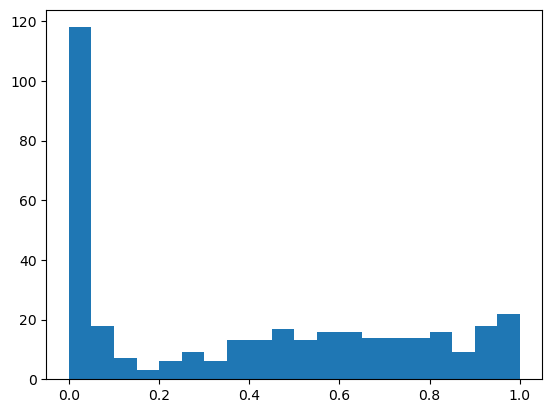

In [329]:
plt.hist(rfc_full.predict_proba(X_test)[:,1],bins=20)

# Add to New dataset

In [14]:
data_df  = data_df[data_df['InspectionID'].isin(input_df.index)]

In [64]:
obs1 = 'Procedures describing the handling of written and oral complaints related to drug products are deficiently written or followed.'
obs2 = 'Procedures designed to prevent microbiological contamination of drug products pmpo1ting to be sterile did not include adequate validation of the aseptic process.'
obs3 = 'The responsibilities and procedures applicable to the quality control unit are not in writing and fully followed.'
obs4 = 'Procedures designed to prevent microbiological contamination of diug products pmpo1ting to be sterile are not established and followed.'
obs5 = 'Buildings used in the manufacturing, processing, packing and holding of a drng product are not maintained in a good state of repair.'
obs6 = 'Aseptic processing areas are deficient regarding the system for monitoring environmental conditions.'
obs7 = 'Determinations of conformance to appropriate written specifications for acceptance are deficient for inprocess materials.'

In [9]:
from difflib import get_close_matches

In [10]:
def get_citations_from_observations(obs_list):

    """ 
    Args: list of observations from 483
        
    Returns: CFR citation numbers
    """
    cfr_list = []

    for obs in obs_list:

        matches = get_close_matches(obs,data_df["LongDescription"].unique())
        cfr_matches = data_df[data_df['LongDescription'].isin(matches)]['ActCFRNumber'].unique()
        cfr = cfr_matches[0]
        print("Observation:",obs)
        print("Matches:",cfr_matches,matches)

        if len(cfr_matches)>1:
            
            print('********************************************************')
            print("Multiple CFR numbers corresponding to observation:",obs)
            print(data_df[data_df['LongDescription'].isin(matches)][['ActCFRNumber','LongDescription']].drop_duplicates())
            print('********************************************************')

        cfr_list.append(cfr)

    return cfr_list    


In [65]:
obs_list = [obs1,obs2,obs3,obs4,obs5,obs6,obs7]
cit_list = get_citations_from_observations(obs_list)

Observation: Procedures describing the handling of written and oral complaints related to drug products are deficiently written or followed.
Matches: ['21 CFR 211.198(a)'] ['Procedures describing the handling of written and oral complaints related to drug products are deficiently written or followed.', 'Procedures describing the handling of written and oral complaints related to drug products are deficiently written or followed .', 'Procedures describing the handling of written and oral complaints related to drug products are not written or followed.']
Observation: Procedures designed to prevent microbiological contamination of drug products pmpo1ting to be sterile did not include adequate validation of the aseptic process.
Matches: ['21 CFR 211.113(b)'] ['Procedures designed to prevent microbiological contamination of drug products purporting to be sterile did not include adequate validation of the aseptic process.', 'Procedures designed to prevent microbiological contamination of dru

In [ ]:
act_df.loc[cit_list]

Classification,OAI,VAI,Total,OAI_weighted
ActCFRNumber,,,,
21 CFR 211.198(a),111.0,271.0,382.0,0.290576
21 CFR 211.113(b),303.0,293.0,596.0,0.508389
21 CFR 211.22(d),303.0,880.0,1183.0,0.256128
21 CFR 211.113(b),303.0,293.0,596.0,0.508389
21 CFR 211.58,41.0,113.0,154.0,0.266234
21 CFR 211.42(c)(10)(iv),190.0,112.0,302.0,0.629139
21 CFR 211.160(b)(3),27.0,62.0,89.0,0.303371


In [87]:
output_table_df = act_df.loc[cit_list].drop('VAI',axis=1)
output_table_df[['OAI','Total']] = output_table_df[['OAI','Total']].astype('int32')
output_table_df['OAI_weighted'] = output_table_df['OAI_weighted'].apply(lambda x: f'{x*100:.1f}%')

In [88]:
output_table_df.columns = ['OAI','Total','OAI(%)']

In [89]:
output_table_df['Observations'] = obs_list
output_table_df = output_table_df[['Observations','OAI','Total','OAI(%)']]

In [100]:
import textwrap
from matplotlib.font_manager import FontProperties

In [105]:
output_table_df['Observations'] = output_table_df['Observations'].apply(lambda x: textwrap.fill(x,width=60))

In [92]:
output_table_df = output_table_df.reset_index()

In [75]:
output_str = output_table_df.to_string(index=False)

(0.0, 1.0, 0.0, 1.0)

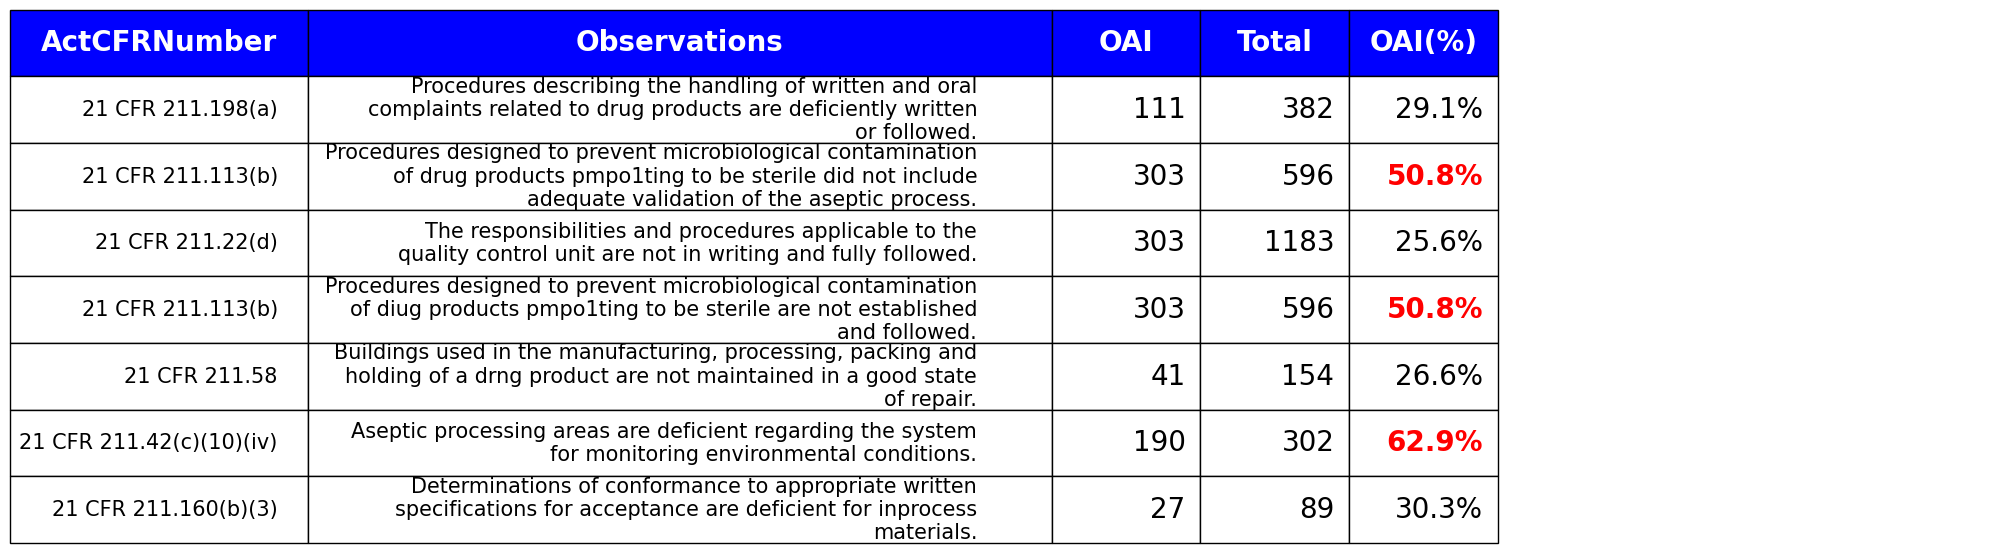

In [135]:
fig, ax = plt.subplots()
table = ax.table(cellText = output_table_df.values, colLabels = output_table_df.columns,loc='left', colWidths = [0.2,0.5,0.1,0.1,0.1], colColours = ['blue','blue','blue','blue','blue'])
table.auto_set_font_size(False)
for (row, col), cell in table._cells.items():
    
    if row == 0:
        cell.get_text().set_color('white')
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

    if col == 0 and row!=0:
        cell.set_fontsize(15)
    elif col == 1 and row!=0:
        cell.set_fontsize(15)
        
    
    else:
      cell.set_fontsize(20)

    
    if col == 4 and row>0:

        oai = float(output_table_df.iloc[row-1,col][:-1])
        

        if oai >= 50:
            cell.get_text().set_color('red')
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_fontsize(20)

        elif oai >= 40:
            cell.get_text().set_color('orange')
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell.set_fontsize(20)

table.scale(3,4)
#ax.set_title("Citation Records",fontsize=20, loc ='left')
ax.axis('off')

In [16]:
data_df['Classification'].value_counts()

Classification
VAI    25363
OAI     9577
Name: count, dtype: int64

In [39]:
tmp = data_df[data_df.InspectionEndDate >= pd.to_datetime('2020-01-01')].groupby('InspectionID')[['ActCFRNumber','LongDescription']].nunique().reset_index()
tmp = tmp.merge(data_df[['InspectionID','Classification']].drop_duplicates(),how='left',on='InspectionID')
tmp = tmp.groupby('ActCFRNumber')['Classification'].value_counts(normalize=False).reset_index()
#tmp = tmp[tmp.Classification == 'OAI'][['ActCFRNumber','proportion']].drop_duplicates()
tmp

,ActCFRNumber,Classification,count
0,1,VAI,255
1,1,OAI,17
2,2,VAI,209
3,2,OAI,6
4,3,VAI,180
5,3,OAI,23
6,4,VAI,137
7,4,OAI,34
8,5,VAI,104
9,5,OAI,53


In [40]:
tmp[tmp.ActCFRNumber == 7]

,ActCFRNumber,Classification,count
12,7,OAI,57
13,7,VAI,45
